# Artificial Neural Networks for Solving Ordinary andPartial Differential Equations 
* [IEEE Transactions on Neural Networks 9(5):987-1000]
* Use a neural network to construct a solution to an ordinary differential equation (ODE) or partial differential equation (PDE) that automatically satisfies the initial conditions (IC) and boundary conditions (BC) of the ODE or PDE for the plain solution
* ODE or(PDE) equation：
1. $$ \frac{d}{dx}\Psi + (x + \frac{1 + 3x^2}{1 + x + x^3})\Psi = x^3 + 2x + x^2 + x^2\frac{1+3x^2}{1+x+x^3}$$
$$\Psi(0)=1, x\in [0,1]$$
It has a trivial solution of the form:
$$\Psi_t(x)=1+xN(x|\theta), N(x|\theta) is DNN$$
Its analytic solution is:
$$
\Psi_a(x) = \frac{e^{-x^2/x}}{1 + x + x^3} + x^2
$$


2. $$ \frac{d}{dx}\Psi + (x + \frac{1}{5})\Psi =e^{\frac{-x}{5}}cos(x)$$
$$\Psi(0)=0, x\in [0,2]$$
It has a trivial solution of the form:
$$\Psi_t(x) = xN(x|\theta), N(x|\theta)is DNN$$
Its analytic solution is:
$$
\Psi_a(x) =e^{\frac{-x}{5}}sin(x)
$$

3. $$ \frac{d^2}{dx^2}\Psi + (x + \frac{1 + 3x^2}{1 + x + x^3})\Psi = x^3 + 2x + x^2 + x^2\frac{1+3x^2}{1+x+x^3}$$
$$\Psi(0)=1, x\in [0,1]$$
Its analytic solution is:
$$\Psi_t(x)=1+xN(x|\theta), N(x|\theta) is DNN$$
Its analytic solution is:
$$
\Psi_a(x) = \frac{e^{-x^2/x}}{1 + x + x^3} + x^2
$$

# Modules for neural networks

In [3]:
import torch

import numpy as np
from torch._C import device
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from torch._C import device
from numpy.core.function_base import linspace
from matplotlib import pyplot as plt
import math
import os
plt.style.use(["science", "notebook", "no-latex"])

In [4]:
def mkdir(path):

    folder = os.path.exists(path)

    if not folder:                   
        os.makedirs(path)            
        print ("---  new folder...  ---")
        print ("---  OK  ---")

    else:
        print ("---  There is this folder!  ---")
for i in range(8):
    mkdir("p%s"%(i+1))

---  new folder...  ---
---  OK  ---
---  new folder...  ---
---  OK  ---
---  new folder...  ---
---  OK  ---
---  new folder...  ---
---  OK  ---
---  new folder...  ---
---  OK  ---
---  new folder...  ---
---  OK  ---
---  new folder...  ---
---  OK  ---
---  new folder...  ---
---  OK  ---


### Constructed neural networks
* active function: sigmoid
* NL: the number of layer
* NN: the number of neuron

In [5]:
class SampleNet(nn.Module):
    def __init__(self,input,NL,NN):
        super(SampleNet,self).__init__()
        self.input_layer = nn.Linear(input,NN)
        self.hidden_layers = nn.ModuleList([nn.Linear(NN,NN) for i in range(NL)])
        self.output_layer = nn.Linear(NN,1)
    def forward(self,x):
        o = self.act(self.input_layer(x))
        for i,li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        output = self.output_layer(o)

        return output
    def act(self,x):
        return x * torch.sigmoid(x)

# P1:$$ \frac{d}{dx}\Psi + (x + \frac{1 + 3x^2}{1 + x + x^3})\Psi = x^3 + 2x + x^2 + x^2\frac{1+3x^2}{1+x+x^3}$$
### define some function

In [6]:
def p1f1(x):
    return x+(1+3*x**2)/(1+x+x**3)

def p1f2(x):
    return x**3+2*x+x**2*(1+3*x**2)/(1+x+x**3)

### define training function

In [7]:
def One_train(x,learning_rate,epochs,path,device):
    """
    x: input
    learning_rate
    epochs
    path
    device:Calls the GPU if it can't be called then uses the CPU
    """
    x.requires_grad = True
    Net = SampleNet(1,8,30).to(device)
    opt = optim.Adam(Net.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net.apply(init_normal)
    Net.train()

    ########## loss
    def loss_a(x):
        """
        
        trivial function: Psi_t(x)=1+xN(x|\theta), N(x|\theta)
        return: loss
        """
        phi_t = 1 + x*Net(x)
        phit_x = torch.autograd.grad(phi_t,x,grad_outputs=torch.ones_like(x).to(device),create_graph=True)[0] 
        f_x = -p1f1(x)*phi_t +p1f2(x)
        loss = torch.sum((phit_x-f_x)**2)
        return loss

    tic = time.time()
    x = torch.FloatTensor(x).reshape(-1,1).to(device)

    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []

        Net.zero_grad()
        loss = loss_a(x)
        loss.backward()
        opt.step()
        Loss.append(loss.item())
        print('Train Epoch:{} Loss:{:.6f}'.format(epoch,loss.item()))
        Loss = np.array(Loss)
        if np.mean(Loss) < Loss_mean:
            checkpoint = {
                'epoch':epoch + 1,
                'state_dict':Net.state_dict(),
                'optimizer':opt.state_dict(),
                'loss':loss.item()
            }
            torch.save(checkpoint,path+"model_One.pt")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))
    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss.txt',np.array(Loss_list))

### define test function

In [8]:
def One_test(x,path,device):
    """
    return : x_y.npz
    """
    Net = SampleNet(1,8,30).to(device)
    Net.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net.eval()
    x = torch.FloatTensor(x).reshape(-1,1).to(device)
    y_pred = 1 + x*Net(x)
    print('Testing over')
    np.savez(path+ 'x_y',x = x.detach().numpy(),y = y_pred.detach().numpy())

### set some parameters: epoch, path, dataset

In [11]:
epochs = 300
path = "./p1/"
train_dx = 10
test_dx = 100
learning_rate = 0.001
x_train = torch.linspace(0,1,train_dx).reshape(-1,1)
x_test = torch.linspace(0,1,test_dx).reshape(-1,1)
y_tru = []
y_err = []


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

One_train(x_train,learning_rate,epochs,path,device)
One_test(x_test,path,device)


Train Epoch:0 Loss:6.097034
Train Epoch:1 Loss:4.578667
Train Epoch:2 Loss:3.621632
Train Epoch:3 Loss:2.958231
Train Epoch:4 Loss:2.494222
Train Epoch:5 Loss:2.123223
Train Epoch:6 Loss:1.808489
Train Epoch:7 Loss:1.585032
Train Epoch:8 Loss:1.438236
Train Epoch:9 Loss:1.304612
Train Epoch:10 Loss:1.217237
Train Epoch:11 Loss:1.173242
Train Epoch:12 Loss:1.112605
Train Epoch:13 Loss:1.072432
Train Epoch:14 Loss:1.036578
Train Epoch:15 Loss:0.971078
Train Epoch:16 Loss:0.916177
Train Epoch:17 Loss:0.843302
Train Epoch:18 Loss:0.756549
Train Epoch:19 Loss:0.682029
Train Epoch:20 Loss:0.596561
Train Epoch:21 Loss:0.520261
Train Epoch:22 Loss:0.459038
Train Epoch:23 Loss:0.398013
Train Epoch:24 Loss:0.355466
Train Epoch:25 Loss:0.321354
Train Epoch:26 Loss:0.290776
Train Epoch:27 Loss:0.272069
Train Epoch:28 Loss:0.249464
Train Epoch:29 Loss:0.229671
Train Epoch:30 Loss:0.210737
Train Epoch:31 Loss:0.187372
Train Epoch:32 Loss:0.169461
Train Epoch:33 Loss:0.149699
Train Epoch:34 Loss:0.13

Train Epoch:299 Loss:0.000102
elapse time in parallel =  1.1180098056793213
Testing over


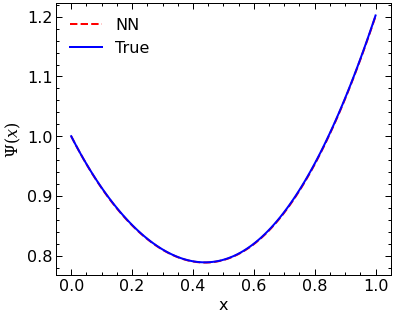

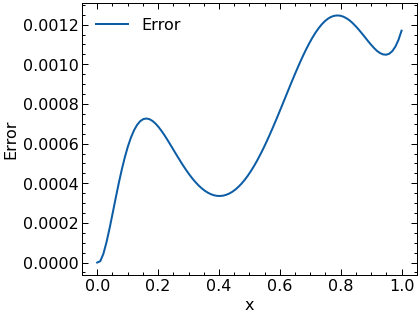

In [12]:

Data = np.load(path + "x_y.npz")

x_test = Data['x']
y_pred = Data['y']
for i in range(test_dx):
    y_tr = math.e**((-x_test[i]**2)/2)/(1+x_test[i]+x_test[i]**3) + x_test[i]**2
    y = y_tr - y_pred[i]
    y_err.append(y)
    y_tru.append(y_tr)
y_error = y_err 
y_true = y_tru

plt.figure(figsize=(6,5))
plt.plot(x_test,y_pred,'r--',label='NN')
plt.plot(x_test,y_true,'b',label = 'True')
plt.xlabel('x')
plt.ylabel('$\Psi(x)$')
plt.legend()
plt.savefig(path + "solution.png",dpi=100,bbox_inches='tight')

plt.figure(figsize=(6,5))
plt.plot(x_test,y_error,label='Error')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()
plt.savefig(path + "Error.png",dpi=100,bbox_inches='tight')

# P2: $$ \frac{d}{dx}\Psi + (x + \frac{1}{5})\Psi =e^{\frac{-x}{5}}cos(x)$$
### define function

In [17]:
def p2f1(x):
    return (torch.exp(-0.2*x))*torch.cos(x)

In [18]:
def One_train(x,learning_rate,epochs,path,device):
    x.requires_grad = True
    Net = SampleNet(1,8,30).to(device)
    opt = optim.Adam(Net.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net.apply(init_normal)
    Net.train()

    ########## loss
    def loss_a(x):
        phi_t = x*Net(x)
        phit_x = torch.autograd.grad(phi_t,x,grad_outputs=torch.ones_like(x).to(device),create_graph=True)[0] 
        f_x = -0.2*phi_t +p2f1(x) # 平凡解Psi_t(x) = xN(x|\theta), N(x|\theta)
        loss = torch.sum((phit_x-f_x)**2)
        return loss

    tic = time.time()
    x = torch.FloatTensor(x).reshape(-1,1).to(device)

    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []

        Net.zero_grad()
        loss = loss_a(x)
        loss.backward()
        opt.step()
        Loss.append(loss.item())
        print('Train Epoch:{} Loss:{:.6f}'.format(epoch,loss.item()))
        Loss = np.array(Loss)
        if np.mean(Loss) < Loss_mean:
            checkpoint = {
                'epoch':epoch + 1,
                'state_dict':Net.state_dict(),
                'optimizer':opt.state_dict(),
                'loss':loss.item()
            }
            torch.save(checkpoint,path+"model_One.pt")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))
    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss.txt',np.array(Loss_list))

In [19]:
def One_test(x,path,device):
    Net = SampleNet(1,8,30).to(device)
    Net.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net.eval()
    x = torch.FloatTensor(x).reshape(-1,1).to(device)
    y_pred = x*Net(x)
    print('Testing over')
    np.savez(path + 'x_y',x = x.detach().numpy(),y = y_pred.detach().numpy())

In [20]:
epochs = 300
path = "./p2/"
train_dx = 10
test_dx = 100
learning_rate = 0.001
x_train = torch.linspace(0,2,train_dx).reshape(-1,1)
x_test = torch.linspace(0,2,test_dx).reshape(-1,1)
y_tru = []
y_err = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
One_train(x_train,learning_rate,epochs,path,device)
One_test(x_test,path,device)

Train Epoch:0 Loss:5.276130
Train Epoch:1 Loss:4.042614
Train Epoch:2 Loss:3.348266
Train Epoch:3 Loss:2.875912
Train Epoch:4 Loss:2.504427
Train Epoch:5 Loss:2.203476
Train Epoch:6 Loss:1.964674
Train Epoch:7 Loss:1.756841
Train Epoch:8 Loss:1.557617
Train Epoch:9 Loss:1.373391
Train Epoch:10 Loss:1.208985
Train Epoch:11 Loss:1.048031
Train Epoch:12 Loss:0.893707
Train Epoch:13 Loss:0.771040
Train Epoch:14 Loss:0.679862
Train Epoch:15 Loss:0.600641
Train Epoch:16 Loss:0.544313
Train Epoch:17 Loss:0.511976
Train Epoch:18 Loss:0.470936
Train Epoch:19 Loss:0.423107
Train Epoch:20 Loss:0.377379
Train Epoch:21 Loss:0.324034
Train Epoch:22 Loss:0.283609
Train Epoch:23 Loss:0.255157
Train Epoch:24 Loss:0.231145
Train Epoch:25 Loss:0.221715
Train Epoch:26 Loss:0.203380
Train Epoch:27 Loss:0.188142
Train Epoch:28 Loss:0.164738
Train Epoch:29 Loss:0.146572
Train Epoch:30 Loss:0.131119
Train Epoch:31 Loss:0.120795
Train Epoch:32 Loss:0.115359
Train Epoch:33 Loss:0.107013
Train Epoch:34 Loss:0.09

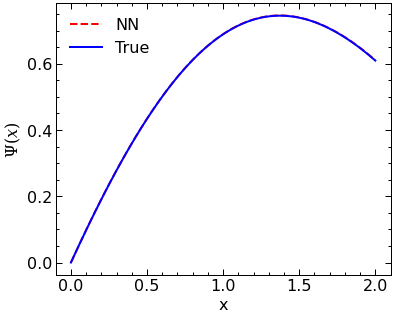

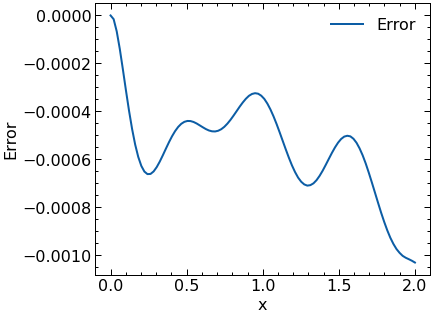

In [21]:
Data = np.load(path + "x_y.npz")
#print(Data['x'])
x_test = Data['x']
y_pred = Data['y']
for i in range(test_dx):
    y_tr = (math.e**(-0.2*x_test[i])) * math.sin(x_test[i])
    y = y_tr - y_pred[i]
    y_err.append(y)
    y_tru.append(y_tr)
#     y_err.appen(y_er)
y_error = y_err 
y_true = y_tru

plt.figure(figsize=(6,5))
plt.plot(x_test,y_pred,'r--',label='NN')
plt.plot(x_test,y_true,'b',label = 'True')
plt.xlabel('x')
plt.ylabel('$\Psi(x)$')
plt.legend()

plt.savefig(path + "solution.png",dpi=100,bbox_inches='tight')

plt.figure(figsize=(6,5))
plt.plot(x_test,y_error,label='Error')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()

plt.savefig(path + "Error.png",dpi=100,bbox_inches='tight')

# P3: $$ \frac{d^2}{dx^2}\Psi + (x + \frac{1 + 3x^2}{1 + x + x^3})\Psi = x^3 + 2x + x^2 + x^2\frac{1+3x^2}{1+x+x^3}$$

# define function

In [22]:
def p3f1(x):
    return -0.2*(torch.exp(-0.2*x))*torch.cos(x)

In [23]:

def One_train(x,learning_rate,epochs,path,device):
    x.requires_grad = True
    Net = SampleNet(1,8,30).to(device)
    opt = optim.Adam(Net.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net.apply(init_normal)
    Net.train()

    ########## loss
    def loss_a(x):
        phi_t = x + (x**2)*Net(x)
        phit_x = torch.autograd.grad(phi_t,x,grad_outputs=torch.ones_like(x).to(device),create_graph=True)[0] 
        phit_xx = torch.autograd.grad(phit_x,x,grad_outputs=torch.ones_like(x).to(device),create_graph=True)[0] 
        f_x = -0.2*phit_x +p3f1(x) - phi_t
        loss = torch.sum((phit_xx-f_x)**2)
        return loss

    tic = time.time()
    x = torch.FloatTensor(x).reshape(-1,1).to(device)

    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []

        Net.zero_grad()
        loss = loss_a(x)
        loss.backward()
        opt.step()
        Loss.append(loss.item())
        print('Train Epoch:{} Loss:{:.6f}'.format(epoch,loss.item()))
        Loss = np.array(Loss)
        if np.mean(Loss) < Loss_mean:
            checkpoint = {
                'epoch':epoch + 1,
                'state_dict':Net.state_dict(),
                'optimizer':opt.state_dict(),
                'loss':loss.item()
            }
            torch.save(checkpoint,path+"model_One.pt")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))
    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss.txt',np.array(Loss_list))



In [24]:
def One_test(x,path,device):
    Net = SampleNet(1,8,30).to(device)
    Net.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net.eval()
    x = torch.FloatTensor(x).reshape(-1,1).to(device)
    y_pred = x+(x**2)*Net(x)
    print('Testing over')
    np.savez(path + 'x_y',x = x.detach().numpy(),y = y_pred.detach().numpy())

In [25]:
epochs = 3000
path = "./p3/"
train_dx = 10
test_dx = 100
learning_rate = 0.001
x_train = torch.linspace(0,2,train_dx).reshape(-1,1)
x_test = torch.linspace(0,2,test_dx).reshape(-1,1)
y_tru = []
y_err = []


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

One_train(x_train,learning_rate,epochs,path,device)
One_test(x_test,path,device)

Train Epoch:0 Loss:88.170143
Train Epoch:1 Loss:7.096647
Train Epoch:2 Loss:4.246731
Train Epoch:3 Loss:10.796307
Train Epoch:4 Loss:12.890080
Train Epoch:5 Loss:11.022164
Train Epoch:6 Loss:7.724508
Train Epoch:7 Loss:4.651056
Train Epoch:8 Loss:2.438087
Train Epoch:9 Loss:1.129530
Train Epoch:10 Loss:0.534253
Train Epoch:11 Loss:0.416423
Train Epoch:12 Loss:0.570299
Train Epoch:13 Loss:0.839728
Train Epoch:14 Loss:1.117859
Train Epoch:15 Loss:1.340483
Train Epoch:16 Loss:1.476707
Train Epoch:17 Loss:1.519162
Train Epoch:18 Loss:1.475573
Train Epoch:19 Loss:1.362273
Train Epoch:20 Loss:1.199536
Train Epoch:21 Loss:1.008380
Train Epoch:22 Loss:0.808415
Train Epoch:23 Loss:0.616480
Train Epoch:24 Loss:0.445818
Train Epoch:25 Loss:0.305656
Train Epoch:26 Loss:0.201123
Train Epoch:27 Loss:0.133420
Train Epoch:28 Loss:0.100249
Train Epoch:29 Loss:0.096452
Train Epoch:30 Loss:0.114844
Train Epoch:31 Loss:0.147161
Train Epoch:32 Loss:0.185058
Train Epoch:33 Loss:0.221033
Train Epoch:34 Loss:

Train Epoch:291 Loss:0.000586
Train Epoch:292 Loss:0.000575
Train Epoch:293 Loss:0.000565
Train Epoch:294 Loss:0.000555
Train Epoch:295 Loss:0.000545
Train Epoch:296 Loss:0.000535
Train Epoch:297 Loss:0.000526
Train Epoch:298 Loss:0.000516
Train Epoch:299 Loss:0.000507
Train Epoch:300 Loss:0.000498
Train Epoch:301 Loss:0.000489
Train Epoch:302 Loss:0.000481
Train Epoch:303 Loss:0.000472
Train Epoch:304 Loss:0.000464
Train Epoch:305 Loss:0.000456
Train Epoch:306 Loss:0.000448
Train Epoch:307 Loss:0.000440
Train Epoch:308 Loss:0.000432
Train Epoch:309 Loss:0.000424
Train Epoch:310 Loss:0.000417
Train Epoch:311 Loss:0.000409
Train Epoch:312 Loss:0.000402
Train Epoch:313 Loss:0.000395
Train Epoch:314 Loss:0.000388
Train Epoch:315 Loss:0.000382
Train Epoch:316 Loss:0.000375
Train Epoch:317 Loss:0.000368
Train Epoch:318 Loss:0.000362
Train Epoch:319 Loss:0.000356
Train Epoch:320 Loss:0.000350
Train Epoch:321 Loss:0.000344
Train Epoch:322 Loss:0.000338
Train Epoch:323 Loss:0.000332
Train Epoc

Train Epoch:575 Loss:0.000037
Train Epoch:576 Loss:0.000036
Train Epoch:577 Loss:0.000036
Train Epoch:578 Loss:0.000036
Train Epoch:579 Loss:0.000036
Train Epoch:580 Loss:0.000035
Train Epoch:581 Loss:0.000035
Train Epoch:582 Loss:0.000035
Train Epoch:583 Loss:0.000035
Train Epoch:584 Loss:0.000035
Train Epoch:585 Loss:0.000034
Train Epoch:586 Loss:0.000034
Train Epoch:587 Loss:0.000034
Train Epoch:588 Loss:0.000034
Train Epoch:589 Loss:0.000034
Train Epoch:590 Loss:0.000034
Train Epoch:591 Loss:0.000033
Train Epoch:592 Loss:0.000033
Train Epoch:593 Loss:0.000033
Train Epoch:594 Loss:0.000033
Train Epoch:595 Loss:0.000033
Train Epoch:596 Loss:0.000032
Train Epoch:597 Loss:0.000032
Train Epoch:598 Loss:0.000032
Train Epoch:599 Loss:0.000032
Train Epoch:600 Loss:0.000032
Train Epoch:601 Loss:0.000031
Train Epoch:602 Loss:0.000031
Train Epoch:603 Loss:0.000031
Train Epoch:604 Loss:0.000031
Train Epoch:605 Loss:0.000031
Train Epoch:606 Loss:0.000031
Train Epoch:607 Loss:0.000030
Train Epoc

Train Epoch:858 Loss:0.000007
Train Epoch:859 Loss:0.000007
Train Epoch:860 Loss:0.000007
Train Epoch:861 Loss:0.000007
Train Epoch:862 Loss:0.000007
Train Epoch:863 Loss:0.000007
Train Epoch:864 Loss:0.000007
Train Epoch:865 Loss:0.000007
Train Epoch:866 Loss:0.000007
Train Epoch:867 Loss:0.000006
Train Epoch:868 Loss:0.000006
Train Epoch:869 Loss:0.000006
Train Epoch:870 Loss:0.000006
Train Epoch:871 Loss:0.000006
Train Epoch:872 Loss:0.000006
Train Epoch:873 Loss:0.000006
Train Epoch:874 Loss:0.000006
Train Epoch:875 Loss:0.000006
Train Epoch:876 Loss:0.000006
Train Epoch:877 Loss:0.000006
Train Epoch:878 Loss:0.000006
Train Epoch:879 Loss:0.000006
Train Epoch:880 Loss:0.000006
Train Epoch:881 Loss:0.000006
Train Epoch:882 Loss:0.000006
Train Epoch:883 Loss:0.000006
Train Epoch:884 Loss:0.000006
Train Epoch:885 Loss:0.000006
Train Epoch:886 Loss:0.000006
Train Epoch:887 Loss:0.000006
Train Epoch:888 Loss:0.000006
Train Epoch:889 Loss:0.000006
Train Epoch:890 Loss:0.000006
Train Epoc

Train Epoch:1157 Loss:0.000014
Train Epoch:1158 Loss:0.000473
Train Epoch:1159 Loss:0.000237
Train Epoch:1160 Loss:0.000043
Train Epoch:1161 Loss:0.000376
Train Epoch:1162 Loss:0.000119
Train Epoch:1163 Loss:0.000066
Train Epoch:1164 Loss:0.000285
Train Epoch:1165 Loss:0.000058
Train Epoch:1166 Loss:0.000073
Train Epoch:1167 Loss:0.000209
Train Epoch:1168 Loss:0.000030
Train Epoch:1169 Loss:0.000067
Train Epoch:1170 Loss:0.000154
Train Epoch:1171 Loss:0.000018
Train Epoch:1172 Loss:0.000053
Train Epoch:1173 Loss:0.000115
Train Epoch:1174 Loss:0.000015
Train Epoch:1175 Loss:0.000037
Train Epoch:1176 Loss:0.000088
Train Epoch:1177 Loss:0.000015
Train Epoch:1178 Loss:0.000021
Train Epoch:1179 Loss:0.000067
Train Epoch:1180 Loss:0.000019
Train Epoch:1181 Loss:0.000008
Train Epoch:1182 Loss:0.000048
Train Epoch:1183 Loss:0.000024
Train Epoch:1184 Loss:0.000001
Train Epoch:1185 Loss:0.000030
Train Epoch:1186 Loss:0.000028
Train Epoch:1187 Loss:0.000001
Train Epoch:1188 Loss:0.000013
Train Ep

Train Epoch:1440 Loss:0.000000
Train Epoch:1441 Loss:0.000000
Train Epoch:1442 Loss:0.000000
Train Epoch:1443 Loss:0.000000
Train Epoch:1444 Loss:0.000000
Train Epoch:1445 Loss:0.000001
Train Epoch:1446 Loss:0.000001
Train Epoch:1447 Loss:0.000003
Train Epoch:1448 Loss:0.000005
Train Epoch:1449 Loss:0.000009
Train Epoch:1450 Loss:0.000017
Train Epoch:1451 Loss:0.000035
Train Epoch:1452 Loss:0.000076
Train Epoch:1453 Loss:0.000171
Train Epoch:1454 Loss:0.000396
Train Epoch:1455 Loss:0.000913
Train Epoch:1456 Loss:0.002010
Train Epoch:1457 Loss:0.003662
Train Epoch:1458 Loss:0.004595
Train Epoch:1459 Loss:0.002514
Train Epoch:1460 Loss:0.000092
Train Epoch:1461 Loss:0.001072
Train Epoch:1462 Loss:0.002497
Train Epoch:1463 Loss:0.000998
Train Epoch:1464 Loss:0.000083
Train Epoch:1465 Loss:0.001455
Train Epoch:1466 Loss:0.001151
Train Epoch:1467 Loss:0.000007
Train Epoch:1468 Loss:0.000860
Train Epoch:1469 Loss:0.000952
Train Epoch:1470 Loss:0.000020
Train Epoch:1471 Loss:0.000575
Train Ep

Train Epoch:1723 Loss:0.000009
Train Epoch:1724 Loss:0.000010
Train Epoch:1725 Loss:0.000011
Train Epoch:1726 Loss:0.000013
Train Epoch:1727 Loss:0.000016
Train Epoch:1728 Loss:0.000020
Train Epoch:1729 Loss:0.000029
Train Epoch:1730 Loss:0.000046
Train Epoch:1731 Loss:0.000076
Train Epoch:1732 Loss:0.000134
Train Epoch:1733 Loss:0.000245
Train Epoch:1734 Loss:0.000457
Train Epoch:1735 Loss:0.000826
Train Epoch:1736 Loss:0.001359
Train Epoch:1737 Loss:0.001794
Train Epoch:1738 Loss:0.001607
Train Epoch:1739 Loss:0.000694
Train Epoch:1740 Loss:0.000035
Train Epoch:1741 Loss:0.000311
Train Epoch:1742 Loss:0.000870
Train Epoch:1743 Loss:0.000789
Train Epoch:1744 Loss:0.000219
Train Epoch:1745 Loss:0.000055
Train Epoch:1746 Loss:0.000431
Train Epoch:1747 Loss:0.000571
Train Epoch:1748 Loss:0.000194
Train Epoch:1749 Loss:0.000010
Train Epoch:1750 Loss:0.000271
Train Epoch:1751 Loss:0.000368
Train Epoch:1752 Loss:0.000128
Train Epoch:1753 Loss:0.000025
Train Epoch:1754 Loss:0.000162
Train Ep

Train Epoch:2008 Loss:0.000003
Train Epoch:2009 Loss:0.000000
Train Epoch:2010 Loss:0.000003
Train Epoch:2011 Loss:0.000008
Train Epoch:2012 Loss:0.000010
Train Epoch:2013 Loss:0.000009
Train Epoch:2014 Loss:0.000006
Train Epoch:2015 Loss:0.000002
Train Epoch:2016 Loss:0.000000
Train Epoch:2017 Loss:0.000000
Train Epoch:2018 Loss:0.000002
Train Epoch:2019 Loss:0.000004
Train Epoch:2020 Loss:0.000006
Train Epoch:2021 Loss:0.000008
Train Epoch:2022 Loss:0.000010
Train Epoch:2023 Loss:0.000012
Train Epoch:2024 Loss:0.000015
Train Epoch:2025 Loss:0.000020
Train Epoch:2026 Loss:0.000028
Train Epoch:2027 Loss:0.000041
Train Epoch:2028 Loss:0.000064
Train Epoch:2029 Loss:0.000106
Train Epoch:2030 Loss:0.000184
Train Epoch:2031 Loss:0.000322
Train Epoch:2032 Loss:0.000554
Train Epoch:2033 Loss:0.000878
Train Epoch:2034 Loss:0.001167
Train Epoch:2035 Loss:0.001116
Train Epoch:2036 Loss:0.000607
Train Epoch:2037 Loss:0.000083
Train Epoch:2038 Loss:0.000077
Train Epoch:2039 Loss:0.000445
Train Ep

Train Epoch:2293 Loss:0.000229
Train Epoch:2294 Loss:0.000456
Train Epoch:2295 Loss:0.000460
Train Epoch:2296 Loss:0.000330
Train Epoch:2297 Loss:0.000332
Train Epoch:2298 Loss:0.000120
Train Epoch:2299 Loss:0.000322
Train Epoch:2300 Loss:0.000182
Train Epoch:2301 Loss:0.000039
Train Epoch:2302 Loss:0.000254
Train Epoch:2303 Loss:0.000033
Train Epoch:2304 Loss:0.000155
Train Epoch:2305 Loss:0.000049
Train Epoch:2306 Loss:0.000117
Train Epoch:2307 Loss:0.000099
Train Epoch:2308 Loss:0.000039
Train Epoch:2309 Loss:0.000083
Train Epoch:2310 Loss:0.000039
Train Epoch:2311 Loss:0.000105
Train Epoch:2312 Loss:0.000016
Train Epoch:2313 Loss:0.000063
Train Epoch:2314 Loss:0.000004
Train Epoch:2315 Loss:0.000064
Train Epoch:2316 Loss:0.000025
Train Epoch:2317 Loss:0.000053
Train Epoch:2318 Loss:0.000013
Train Epoch:2319 Loss:0.000025
Train Epoch:2320 Loss:0.000012
Train Epoch:2321 Loss:0.000024
Train Epoch:2322 Loss:0.000027
Train Epoch:2323 Loss:0.000025
Train Epoch:2324 Loss:0.000028
Train Ep

Train Epoch:2577 Loss:0.000387
Train Epoch:2578 Loss:0.000321
Train Epoch:2579 Loss:0.000210
Train Epoch:2580 Loss:0.000267
Train Epoch:2581 Loss:0.000044
Train Epoch:2582 Loss:0.000105
Train Epoch:2583 Loss:0.000241
Train Epoch:2584 Loss:0.000095
Train Epoch:2585 Loss:0.000152
Train Epoch:2586 Loss:0.000051
Train Epoch:2587 Loss:0.000051
Train Epoch:2588 Loss:0.000139
Train Epoch:2589 Loss:0.000076
Train Epoch:2590 Loss:0.000109
Train Epoch:2591 Loss:0.000015
Train Epoch:2592 Loss:0.000049
Train Epoch:2593 Loss:0.000060
Train Epoch:2594 Loss:0.000066
Train Epoch:2595 Loss:0.000086
Train Epoch:2596 Loss:0.000029
Train Epoch:2597 Loss:0.000043
Train Epoch:2598 Loss:0.000002
Train Epoch:2599 Loss:0.000033
Train Epoch:2600 Loss:0.000032
Train Epoch:2601 Loss:0.000050
Train Epoch:2602 Loss:0.000063
Train Epoch:2603 Loss:0.000051
Train Epoch:2604 Loss:0.000060
Train Epoch:2605 Loss:0.000034
Train Epoch:2606 Loss:0.000034
Train Epoch:2607 Loss:0.000013
Train Epoch:2608 Loss:0.000010
Train Ep

Train Epoch:2861 Loss:0.000061
Train Epoch:2862 Loss:0.000011
Train Epoch:2863 Loss:0.000129
Train Epoch:2864 Loss:0.000184
Train Epoch:2865 Loss:0.000086
Train Epoch:2866 Loss:0.000003
Train Epoch:2867 Loss:0.000046
Train Epoch:2868 Loss:0.000119
Train Epoch:2869 Loss:0.000097
Train Epoch:2870 Loss:0.000021
Train Epoch:2871 Loss:0.000006
Train Epoch:2872 Loss:0.000055
Train Epoch:2873 Loss:0.000082
Train Epoch:2874 Loss:0.000048
Train Epoch:2875 Loss:0.000006
Train Epoch:2876 Loss:0.000009
Train Epoch:2877 Loss:0.000040
Train Epoch:2878 Loss:0.000054
Train Epoch:2879 Loss:0.000032
Train Epoch:2880 Loss:0.000005
Train Epoch:2881 Loss:0.000003
Train Epoch:2882 Loss:0.000021
Train Epoch:2883 Loss:0.000035
Train Epoch:2884 Loss:0.000029
Train Epoch:2885 Loss:0.000012
Train Epoch:2886 Loss:0.000001
Train Epoch:2887 Loss:0.000004
Train Epoch:2888 Loss:0.000014
Train Epoch:2889 Loss:0.000022
Train Epoch:2890 Loss:0.000021
Train Epoch:2891 Loss:0.000014
Train Epoch:2892 Loss:0.000006
Train Ep

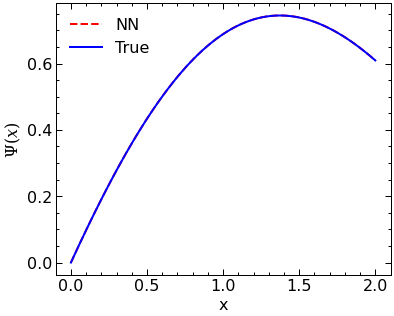

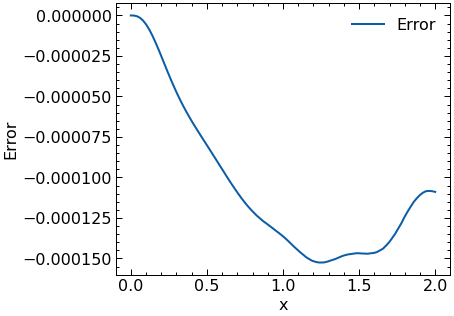

In [26]:
Data = np.load(path + "x_y.npz")
x_test = Data['x']
y_pred = Data['y']
for i in range(test_dx):
    y_tr = (math.e**(-0.2*x_test[i])) * math.sin(x_test[i])
    y = y_tr - y_pred[i]
    y_err.append(y)
    y_tru.append(y_tr)
y_error = y_err 
y_true = y_tru

plt.figure(figsize=(6,5))
plt.plot(x_test,y_pred,'r--',label='NN')
plt.plot(x_test,y_true,'b',label = 'True')
plt.xlabel('x')
plt.ylabel('$\Psi(x)$')
plt.legend()

plt.savefig(path + "solution.png",dpi=100,bbox_inches='tight')

plt.figure(figsize=(6,5))
plt.plot(x_test,y_error,label='Error')
plt.xlabel('x')
plt.ylabel('Error')
plt.legend()

plt.savefig(path + "Error.png",dpi=100,bbox_inches='tight')

# P4:  $$ \frac{d}{dx}{Ψ_1} = cos(x) + Ψ_1^2  + Ψ_2 − (1 + x^2 + sin^2(x))$$
# $$\frac{d}{dx}{Ψ_2} = 2x − (1 + x^2)sin(x) + Ψ_1Ψ_2$$

In [57]:
def One_train(x,learning_rate,epochs,path,device):
    """
    construct two NN
    """
    x.requires_grad = True
    Net0 = SampleNet(1,8,30).to(device)
    Net1 = SampleNet(1,8,30).to(device)
    opt0 = optim.Adam(Net0.parameters(),lr = learning_rate,betas=(0.9,0.99)) 
    opt1 = optim.Adam(Net1.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net0.apply(init_normal)
    Net1.apply(init_normal)

    Net0.train()
    Net1.train()


    ########## loss
    def loss_a(x):
        phi_t1 = x*Net0(x)
        phi_t2 = 1 + x*Net1(x)
        phit1_x = torch.autograd.grad(phi_t1,x,grad_outputs=torch.ones_like(x).to(device),create_graph=True)[0] 
        phit2_x = torch.autograd.grad(phi_t2,x,grad_outputs=torch.ones_like(x).to(device),create_graph=True)[0]
        # TWO trivial solution
        f1_x = torch.cos(x) + phi_t1**2 + phi_t2 - (1 + x**2 + (torch.sin(x))**2)
        f2_x = 2*x - (1 + x**2)*torch.sin(x) + phi_t1 * phi_t2

        loss1 = torch.sum((phit1_x-f1_x)**2)
        loss2 = torch.sum((phit2_x-f2_x)**2)

        return loss1,loss2

    tic = time.time()
    x = torch.FloatTensor(x).reshape(-1,1).to(device)

    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []
        Loss_t1 = []
        Loss_t2 = []

        Net0.zero_grad()
        Net1.zero_grad()

        loss1,loss2 = loss_a(x)
        loss = loss1 + loss2
        loss.backward()
        opt0.step()
        opt1.step()

        Loss.append((loss1 + loss2).item())
        Loss_t1.append(loss1)
        Loss_t2.append(loss2)

        print('Train Epoch:{} Loss1:{:.6f},Loss2:{:.6f}'.format(epoch,loss1.item(),loss2.item()))
        Loss = np.array(Loss)
        if np.mean(Loss) < Loss_mean:
            checkpoint0 = {
                'epoch':epoch + 1,
                'state_dict':Net0.state_dict(),
                'optimizer':opt0.state_dict(),
                'loss':loss1.item()
            }
            checkpoint1 ={
                'epoch':epoch + 1,
                'state_dict':Net1.state_dict(),
                'optimizer':opt1.state_dict(),
                'loss':loss2.item()               
            }
            torch.save(checkpoint0,path+"model_One.pt")
            torch.save(checkpoint1,path+"model_Two.pt")
            print("save model")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))


    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss_all.txt',np.array(Loss_list))


In [58]:
def One_test(x,path,device):
    Net0 = SampleNet(1,8,30).to(device)
    Net0.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net0.eval()


    Net1 = SampleNet(1,8,30).to(device)
    Net1.load_state_dict(torch.load(path + "model_Two.pt",map_location=device)['state_dict'])
    Net1.eval() 

    x = torch.FloatTensor(x).reshape(-1,1).to(device)
    y_pred_t1 = x * Net0(x)
    y_pred_t2 = 1 + x * Net1(x)
    print('Testing over')
    np.savez(path + 'x_yt1',x = x.detach().numpy(),y = y_pred_t1.detach().numpy())
    np.savez(path + 'x_yt2',x = x.detach().numpy(),y = y_pred_t2.detach().numpy())

In [59]:
epochs = 1000
path = "./p4/"
train_dx = 10
test_dx = 100
learning_rate = 0.01
x_train = torch.linspace(0,3,train_dx).reshape(-1,1)
x_test = torch.linspace(0,3,test_dx).reshape(-1,1)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

One_train(x_train,learning_rate,epochs,path,device)
One_test(x_test,path,device)







Train Epoch:0 Loss1:2353494.500000,Loss2:44194.171875
Train Epoch:1 Loss1:273.132019,Loss2:84.876869
Train Epoch:2 Loss1:265.085815,Loss2:18.743689
Train Epoch:3 Loss1:1159.765869,Loss2:45.154724
Train Epoch:4 Loss1:2723.127441,Loss2:435.982483
Train Epoch:5 Loss1:3397.556396,Loss2:358.438629
Train Epoch:6 Loss1:1208.918823,Loss2:580.683350
Train Epoch:7 Loss1:270.625153,Loss2:251.616943
Train Epoch:8 Loss1:137.675278,Loss2:6.944870
Train Epoch:9 Loss1:202.497620,Loss2:56.328373
Train Epoch:10 Loss1:219.873871,Loss2:53.698544
Train Epoch:11 Loss1:164.846695,Loss2:24.402985
Train Epoch:12 Loss1:83.036125,Loss2:52.726723
Train Epoch:13 Loss1:33.947937,Loss2:184.891983
Train Epoch:14 Loss1:28.096909,Loss2:208.034409
Train Epoch:15 Loss1:47.546974,Loss2:59.278843
Train Epoch:16 Loss1:66.141365,Loss2:37.981998
Train Epoch:17 Loss1:50.545822,Loss2:155.091278
Train Epoch:18 Loss1:49.206177,Loss2:142.749802
Train Epoch:19 Loss1:56.818115,Loss2:48.148716
Train Epoch:20 Loss1:47.733536,Loss2:7.7

Train Epoch:160 Loss1:0.077959,Loss2:0.008930
save model
Train Epoch:161 Loss1:0.077198,Loss2:0.008834
save model
Train Epoch:162 Loss1:0.076435,Loss2:0.008786
save model
Train Epoch:163 Loss1:0.075687,Loss2:0.008762
save model
Train Epoch:164 Loss1:0.074964,Loss2:0.008657
save model
Train Epoch:165 Loss1:0.074251,Loss2:0.008564
save model
Train Epoch:166 Loss1:0.073526,Loss2:0.008507
save model
Train Epoch:167 Loss1:0.072802,Loss2:0.008431
save model
Train Epoch:168 Loss1:0.072099,Loss2:0.008373
save model
Train Epoch:169 Loss1:0.071413,Loss2:0.008294
save model
Train Epoch:170 Loss1:0.070740,Loss2:0.008179
save model
Train Epoch:171 Loss1:0.070083,Loss2:0.008081
save model
Train Epoch:172 Loss1:0.069428,Loss2:0.007981
save model
Train Epoch:173 Loss1:0.068767,Loss2:0.007890
save model
Train Epoch:174 Loss1:0.068111,Loss2:0.007815
save model
Train Epoch:175 Loss1:0.067467,Loss2:0.007716
save model
Train Epoch:176 Loss1:0.066832,Loss2:0.007611
save model
Train Epoch:177 Loss1:0.066195,

save model
Train Epoch:319 Loss1:0.010096,Loss2:0.000919
save model
Train Epoch:320 Loss1:0.009957,Loss2:0.000903
save model
Train Epoch:321 Loss1:0.009821,Loss2:0.000886
save model
Train Epoch:322 Loss1:0.009687,Loss2:0.000870
save model
Train Epoch:323 Loss1:0.009557,Loss2:0.000855
save model
Train Epoch:324 Loss1:0.009430,Loss2:0.000839
save model
Train Epoch:325 Loss1:0.009306,Loss2:0.000824
save model
Train Epoch:326 Loss1:0.009185,Loss2:0.000810
save model
Train Epoch:327 Loss1:0.009066,Loss2:0.000795
save model
Train Epoch:328 Loss1:0.008951,Loss2:0.000781
save model
Train Epoch:329 Loss1:0.008838,Loss2:0.000767
save model
Train Epoch:330 Loss1:0.008728,Loss2:0.000754
save model
Train Epoch:331 Loss1:0.008620,Loss2:0.000741
save model
Train Epoch:332 Loss1:0.008515,Loss2:0.000728
save model
Train Epoch:333 Loss1:0.008413,Loss2:0.000715
save model
Train Epoch:334 Loss1:0.008313,Loss2:0.000703
save model
Train Epoch:335 Loss1:0.008215,Loss2:0.000690
save model
Train Epoch:336 Loss

Train Epoch:504 Loss1:0.003202,Loss2:0.002021
Train Epoch:505 Loss1:0.002168,Loss2:0.003889
Train Epoch:506 Loss1:0.002146,Loss2:0.001729
save model
Train Epoch:507 Loss1:0.002067,Loss2:0.003649
Train Epoch:508 Loss1:0.002100,Loss2:0.001418
save model
Train Epoch:509 Loss1:0.002121,Loss2:0.002971
Train Epoch:510 Loss1:0.002076,Loss2:0.000878
save model
Train Epoch:511 Loss1:0.002633,Loss2:0.002357
Train Epoch:512 Loss1:0.001909,Loss2:0.000484
save model
Train Epoch:513 Loss1:0.002428,Loss2:0.002164
Train Epoch:514 Loss1:0.002000,Loss2:0.000402
Train Epoch:515 Loss1:0.001963,Loss2:0.002003
Train Epoch:516 Loss1:0.001933,Loss2:0.000441
save model
Train Epoch:517 Loss1:0.001818,Loss2:0.001799
Train Epoch:518 Loss1:0.001803,Loss2:0.000524
save model
Train Epoch:519 Loss1:0.001786,Loss2:0.001347
Train Epoch:520 Loss1:0.001907,Loss2:0.000642
Train Epoch:521 Loss1:0.001759,Loss2:0.000823
Train Epoch:522 Loss1:0.001978,Loss2:0.000709
Train Epoch:523 Loss1:0.001849,Loss2:0.000442
save model
Tra

Train Epoch:688 Loss1:0.885345,Loss2:0.726979
Train Epoch:689 Loss1:0.085399,Loss2:1.703958
Train Epoch:690 Loss1:0.687988,Loss2:0.097043
Train Epoch:691 Loss1:1.179910,Loss2:1.136802
Train Epoch:692 Loss1:0.146747,Loss2:0.417314
Train Epoch:693 Loss1:0.395176,Loss2:0.344508
Train Epoch:694 Loss1:0.953234,Loss2:0.861323
Train Epoch:695 Loss1:0.344122,Loss2:0.155947
Train Epoch:696 Loss1:0.064819,Loss2:0.556494
Train Epoch:697 Loss1:0.516253,Loss2:0.491955
Train Epoch:698 Loss1:0.317482,Loss2:0.132498
Train Epoch:699 Loss1:0.034937,Loss2:0.729397
Train Epoch:700 Loss1:0.148038,Loss2:0.129266
Train Epoch:701 Loss1:0.202512,Loss2:0.327422
Train Epoch:702 Loss1:0.089368,Loss2:0.593483
Train Epoch:703 Loss1:0.019164,Loss2:0.015685
Train Epoch:704 Loss1:0.057186,Loss2:0.432013
Train Epoch:705 Loss1:0.112322,Loss2:0.274364
Train Epoch:706 Loss1:0.062336,Loss2:0.078230
Train Epoch:707 Loss1:0.007814,Loss2:0.337657
Train Epoch:708 Loss1:0.114285,Loss2:0.028852
Train Epoch:709 Loss1:0.152692,Los

save model
Train Epoch:861 Loss1:0.000603,Loss2:0.000211
save model
Train Epoch:862 Loss1:0.000600,Loss2:0.000210
save model
Train Epoch:863 Loss1:0.000597,Loss2:0.000209
save model
Train Epoch:864 Loss1:0.000594,Loss2:0.000208
save model
Train Epoch:865 Loss1:0.000592,Loss2:0.000207
save model
Train Epoch:866 Loss1:0.000588,Loss2:0.000206
save model
Train Epoch:867 Loss1:0.000586,Loss2:0.000206
save model
Train Epoch:868 Loss1:0.000583,Loss2:0.000204
save model
Train Epoch:869 Loss1:0.000581,Loss2:0.000203
save model
Train Epoch:870 Loss1:0.000578,Loss2:0.000203
save model
Train Epoch:871 Loss1:0.000575,Loss2:0.000202
save model
Train Epoch:872 Loss1:0.000573,Loss2:0.000201
save model
Train Epoch:873 Loss1:0.000570,Loss2:0.000200
save model
Train Epoch:874 Loss1:0.000568,Loss2:0.000199
save model
Train Epoch:875 Loss1:0.000565,Loss2:0.000199
save model
Train Epoch:876 Loss1:0.000562,Loss2:0.000198
save model
Train Epoch:877 Loss1:0.000560,Loss2:0.000197
save model
Train Epoch:878 Loss

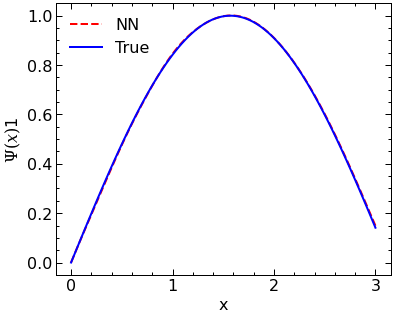

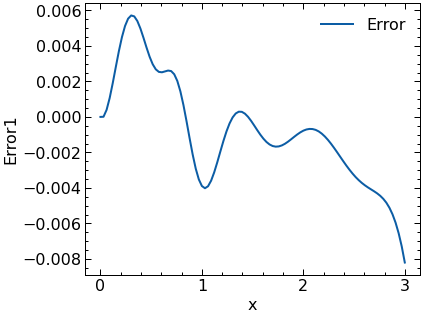

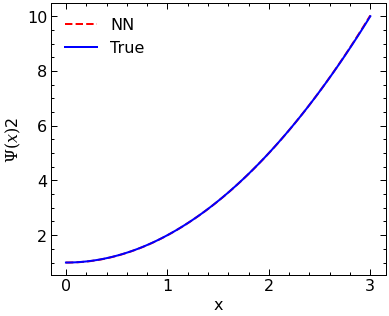

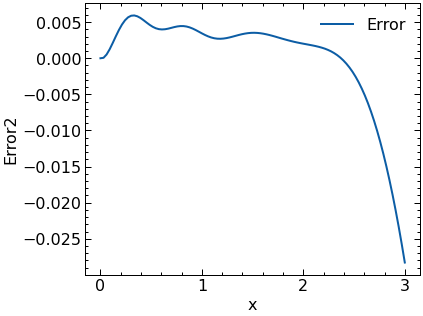

In [60]:
Data1 = np.load(path + "x_yt1.npz")
Data2 = np.load(path + "x_yt2.npz")

def plot_t(Data,index):
    y_tru = []
    y_err = []
    x_test = Data['x']
    y_pred = Data['y']
    for i in range(test_dx):
        y_tr =(1-index)*math.sin(x_test[i]) + (1+ x_test[i]**2) * index
        y = y_tr - y_pred[i]
        y_err.append(y)
        y_tru.append(y_tr)
    #     y_err.appen(y_er)
    y_error = y_err 
    y_true = y_tru
    plt.figure(figsize=(6,5))
    plt.plot(x_test,y_pred,'r--',label='NN')
    plt.plot(x_test,y_true,'b',label = 'True')
    plt.xlabel('x')
    plt.ylabel('$\Psi(x)$' + str(int(index + 1)))
    plt.legend()
    plt.savefig(path + str(int(index + 1))+"solution.png",dpi=100,bbox_inches='tight')

    plt.figure(figsize=(6,5))
    plt.plot(x_test,y_error,label='Error')
    plt.xlabel('x')
    plt.ylabel('Error'+str(int(index + 1)))
    plt.legend()
    plt.savefig(path + str(int(index + 1))+"Error.png",dpi=100,bbox_inches='tight')


plot_t(Data1,0)
plot_t(Data2,1)

# PDE:P5-P8

# P5:$$∇_2Ψ(x, y) = e^{−x}(x − 2 + y^3 + 6y)$$

In [74]:
def f0(x):
    return x**3
def f1(x):
    return (1 + x**3) * torch.exp(-torch.ones_like(x))
def g0(x):
    return x*torch.exp(-x)
def g1(x):
    return (x+1)*torch.exp(-x)

def A(x1,x2):
    return (1-x1) * f0(x2) + x1 * f1(x2) + (1-x2) * (g0(x1)-((1-x1)*g0(torch.zeros_like(x1)) + x1*g0(torch.ones_like(x1)))) +x2 * (g1(x1) - ((1-x1)*g1(torch.zeros_like(x1)) + x1 * g1(torch.ones_like(x1))))

In [75]:

def One_train(x1,x2,learning_rate,epochs,path,device):
    """
    construct two NN
    x1,x2: input
    learning_rate: 学习率
    """
    x1,x2 = torch.meshgrid(x1,x2)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)

    Net = SampleNet(2,8,30).to(device)
    opt = optim.Adam(Net.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net.apply(init_normal)
    Net.train()



    ########## loss
    def loss_a(x1,x2):
        x1.requires_grad = True
        x2.requires_grad = True
        input = torch.cat((x1,x2),1)
        # trivial solution
        phi_t = A(x1,x2) + x1*(1-x1)*x2*(1-x2)*Net(input)
        phit_x1 = torch.autograd.grad(phi_t,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x2 = torch.autograd.grad(phi_t,x2,grad_outputs=torch.ones_like(x2).to(device),create_graph=True)[0]
        phit_x11 = torch.autograd.grad(phit_x1,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x22 = torch.autograd.grad(phit_x2,x2,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]        
        f_x = (x1 - 2 + x2**3 +6 * x2 )*torch.exp(-x1)
        loss = torch.sum((phit_x11 + phit_x22-f_x)**2)
  

        return loss

    tic = time.time()
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)


    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []
        Net.zero_grad()

        loss = loss_a(x1,x2)
        loss.backward()
        opt.step()
        Loss.append(loss.item())
        print('Train Epoch:{} Loss:{:.6f}'.format(epoch,loss.item()))
        Loss = np.array(Loss)
        if np.mean(Loss) < Loss_mean:
            checkpoint0 = {
                'epoch':epoch + 1,
                'state_dict':Net.state_dict(),
                'optimizer':opt.state_dict(),
                'loss':loss.item()
            }
            torch.save(checkpoint0,path+"model_One.pt")
            print("save model")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))


    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss_all.txt',np.array(Loss_list))

In [76]:
def One_test(x1,x2,path,device):
    Net = SampleNet(2,8,30).to(device)
    Net.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net.eval()

    x1,x2 = torch.meshgrid(x1,x2)
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)
    input = torch.cat((x1,x2),1)
    y_pred_t1 = A(x1,x2) + x1*(1-x1)*x2*(1-x2)*Net(input)
    print('Testing over')
    np.savez(path + 'x1_x2_y',x1 = x1.detach().numpy(),x2 = x2.detach().numpy(),y = y_pred_t1.detach().numpy())

In [78]:
epochs = 3000
path = "./p5/"
train_dx = 10
test_dx = 100
learning_rate = 0.001

x_train1 = torch.linspace(0,1,10)
x_train2 = torch.linspace(0,1,10)


x_test1 = torch.linspace(0,1,30)
x_test2 = torch.linspace(0,1,30)




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

One_train(x_train1,x_train2,learning_rate,epochs,path,device)
One_test(x_test1,x_test2,path,device)

Train Epoch:0 Loss:14.127025
save model
Train Epoch:1 Loss:12.109616
save model
Train Epoch:2 Loss:10.270710
save model
Train Epoch:3 Loss:8.583056
save model
Train Epoch:4 Loss:7.030728
save model
Train Epoch:5 Loss:5.608443
save model
Train Epoch:6 Loss:4.325031
save model
Train Epoch:7 Loss:3.205062
save model
Train Epoch:8 Loss:2.287071
save model
Train Epoch:9 Loss:1.616191
save model
Train Epoch:10 Loss:1.225013
save model
Train Epoch:11 Loss:1.101548
save model
Train Epoch:12 Loss:1.160046
Train Epoch:13 Loss:1.255673
Train Epoch:14 Loss:1.261884
Train Epoch:15 Loss:1.136741
Train Epoch:16 Loss:0.916223
save model
Train Epoch:17 Loss:0.668001
save model
Train Epoch:18 Loss:0.452343
save model
Train Epoch:19 Loss:0.304111
save model
Train Epoch:20 Loss:0.231353
save model
Train Epoch:21 Loss:0.222529
save model
Train Epoch:22 Loss:0.256076
Train Epoch:23 Loss:0.308614
Train Epoch:24 Loss:0.360344
Train Epoch:25 Loss:0.397644
Train Epoch:26 Loss:0.413529
Train Epoch:27 Loss:0.4068

save model
Train Epoch:219 Loss:0.001660
save model
Train Epoch:220 Loss:0.001640
save model
Train Epoch:221 Loss:0.001619
save model
Train Epoch:222 Loss:0.001599
save model
Train Epoch:223 Loss:0.001580
save model
Train Epoch:224 Loss:0.001560
save model
Train Epoch:225 Loss:0.001541
save model
Train Epoch:226 Loss:0.001522
save model
Train Epoch:227 Loss:0.001503
save model
Train Epoch:228 Loss:0.001484
save model
Train Epoch:229 Loss:0.001466
save model
Train Epoch:230 Loss:0.001448
save model
Train Epoch:231 Loss:0.001430
save model
Train Epoch:232 Loss:0.001412
save model
Train Epoch:233 Loss:0.001394
save model
Train Epoch:234 Loss:0.001377
save model
Train Epoch:235 Loss:0.001360
save model
Train Epoch:236 Loss:0.001343
save model
Train Epoch:237 Loss:0.001326
save model
Train Epoch:238 Loss:0.001310
save model
Train Epoch:239 Loss:0.001293
save model
Train Epoch:240 Loss:0.001277
save model
Train Epoch:241 Loss:0.001261
save model
Train Epoch:242 Loss:0.001245
save model
Train

save model
Train Epoch:422 Loss:0.000137
save model
Train Epoch:423 Loss:0.000136
save model
Train Epoch:424 Loss:0.000135
save model
Train Epoch:425 Loss:0.000134
save model
Train Epoch:426 Loss:0.000133
save model
Train Epoch:427 Loss:0.000133
save model
Train Epoch:428 Loss:0.000132
save model
Train Epoch:429 Loss:0.000131
save model
Train Epoch:430 Loss:0.000130
save model
Train Epoch:431 Loss:0.000129
save model
Train Epoch:432 Loss:0.000129
save model
Train Epoch:433 Loss:0.000128
save model
Train Epoch:434 Loss:0.000127
save model
Train Epoch:435 Loss:0.000127
save model
Train Epoch:436 Loss:0.000126
save model
Train Epoch:437 Loss:0.000125
save model
Train Epoch:438 Loss:0.000124
save model
Train Epoch:439 Loss:0.000124
save model
Train Epoch:440 Loss:0.000123
save model
Train Epoch:441 Loss:0.000123
save model
Train Epoch:442 Loss:0.000122
save model
Train Epoch:443 Loss:0.000121
save model
Train Epoch:444 Loss:0.000121
save model
Train Epoch:445 Loss:0.000120
save model
Train

save model
Train Epoch:622 Loss:0.000068
save model
Train Epoch:623 Loss:0.000068
save model
Train Epoch:624 Loss:0.000067
save model
Train Epoch:625 Loss:0.000067
save model
Train Epoch:626 Loss:0.000067
save model
Train Epoch:627 Loss:0.000067
save model
Train Epoch:628 Loss:0.000066
save model
Train Epoch:629 Loss:0.000066
save model
Train Epoch:630 Loss:0.000066
save model
Train Epoch:631 Loss:0.000066
save model
Train Epoch:632 Loss:0.000066
save model
Train Epoch:633 Loss:0.000065
save model
Train Epoch:634 Loss:0.000065
save model
Train Epoch:635 Loss:0.000065
save model
Train Epoch:636 Loss:0.000065
save model
Train Epoch:637 Loss:0.000065
save model
Train Epoch:638 Loss:0.000064
save model
Train Epoch:639 Loss:0.000064
save model
Train Epoch:640 Loss:0.000064
save model
Train Epoch:641 Loss:0.000064
save model
Train Epoch:642 Loss:0.000063
save model
Train Epoch:643 Loss:0.000063
save model
Train Epoch:644 Loss:0.000063
save model
Train Epoch:645 Loss:0.000063
save model
Train

Train Epoch:853 Loss:0.000776
Train Epoch:854 Loss:0.001197
Train Epoch:855 Loss:0.000449
Train Epoch:856 Loss:0.000057
Train Epoch:857 Loss:0.000669
Train Epoch:858 Loss:0.000726
Train Epoch:859 Loss:0.000094
Train Epoch:860 Loss:0.000233
Train Epoch:861 Loss:0.000615
Train Epoch:862 Loss:0.000244
Train Epoch:863 Loss:0.000050
Train Epoch:864 Loss:0.000382
Train Epoch:865 Loss:0.000313
Train Epoch:866 Loss:0.000033
Train Epoch:867 Loss:0.000179
Train Epoch:868 Loss:0.000295
Train Epoch:869 Loss:0.000087
Train Epoch:870 Loss:0.000060
Train Epoch:871 Loss:0.000217
Train Epoch:872 Loss:0.000147
Train Epoch:873 Loss:0.000026
save model
Train Epoch:874 Loss:0.000118
Train Epoch:875 Loss:0.000163
Train Epoch:876 Loss:0.000053
Train Epoch:877 Loss:0.000043
Train Epoch:878 Loss:0.000124
Train Epoch:879 Loss:0.000093
Train Epoch:880 Loss:0.000026
Train Epoch:881 Loss:0.000060
Train Epoch:882 Loss:0.000098
Train Epoch:883 Loss:0.000056
Train Epoch:884 Loss:0.000025
save model
Train Epoch:885 Lo

Train Epoch:1121 Loss:0.000040
Train Epoch:1122 Loss:0.000013
Train Epoch:1123 Loss:0.000012
Train Epoch:1124 Loss:0.000031
Train Epoch:1125 Loss:0.000039
Train Epoch:1126 Loss:0.000026
Train Epoch:1127 Loss:0.000011
Train Epoch:1128 Loss:0.000011
Train Epoch:1129 Loss:0.000022
Train Epoch:1130 Loss:0.000029
Train Epoch:1131 Loss:0.000024
Train Epoch:1132 Loss:0.000013
Train Epoch:1133 Loss:0.000009
save model
Train Epoch:1134 Loss:0.000012
Train Epoch:1135 Loss:0.000018
Train Epoch:1136 Loss:0.000022
Train Epoch:1137 Loss:0.000020
Train Epoch:1138 Loss:0.000015
Train Epoch:1139 Loss:0.000010
Train Epoch:1140 Loss:0.000008
save model
Train Epoch:1141 Loss:0.000009
Train Epoch:1142 Loss:0.000012
Train Epoch:1143 Loss:0.000015
Train Epoch:1144 Loss:0.000017
Train Epoch:1145 Loss:0.000019
Train Epoch:1146 Loss:0.000019
Train Epoch:1147 Loss:0.000019
Train Epoch:1148 Loss:0.000019
Train Epoch:1149 Loss:0.000019
Train Epoch:1150 Loss:0.000021
Train Epoch:1151 Loss:0.000023
Train Epoch:1152 

Train Epoch:1387 Loss:0.000047
Train Epoch:1388 Loss:0.000017
Train Epoch:1389 Loss:0.000003
save model
Train Epoch:1390 Loss:0.000015
Train Epoch:1391 Loss:0.000034
Train Epoch:1392 Loss:0.000042
Train Epoch:1393 Loss:0.000034
Train Epoch:1394 Loss:0.000018
Train Epoch:1395 Loss:0.000006
Train Epoch:1396 Loss:0.000004
Train Epoch:1397 Loss:0.000011
Train Epoch:1398 Loss:0.000020
Train Epoch:1399 Loss:0.000028
Train Epoch:1400 Loss:0.000030
Train Epoch:1401 Loss:0.000028
Train Epoch:1402 Loss:0.000023
Train Epoch:1403 Loss:0.000017
Train Epoch:1404 Loss:0.000011
Train Epoch:1405 Loss:0.000007
Train Epoch:1406 Loss:0.000005
Train Epoch:1407 Loss:0.000004
Train Epoch:1408 Loss:0.000003
save model
Train Epoch:1409 Loss:0.000004
Train Epoch:1410 Loss:0.000005
Train Epoch:1411 Loss:0.000006
Train Epoch:1412 Loss:0.000010
Train Epoch:1413 Loss:0.000017
Train Epoch:1414 Loss:0.000032
Train Epoch:1415 Loss:0.000060
Train Epoch:1416 Loss:0.000106
Train Epoch:1417 Loss:0.000174
Train Epoch:1418 

Train Epoch:1654 Loss:0.000003
Train Epoch:1655 Loss:0.000005
Train Epoch:1656 Loss:0.000010
Train Epoch:1657 Loss:0.000020
Train Epoch:1658 Loss:0.000040
Train Epoch:1659 Loss:0.000073
Train Epoch:1660 Loss:0.000096
Train Epoch:1661 Loss:0.000089
Train Epoch:1662 Loss:0.000078
Train Epoch:1663 Loss:0.000152
Train Epoch:1664 Loss:0.000329
Train Epoch:1665 Loss:0.000605
Train Epoch:1666 Loss:0.000969
Train Epoch:1667 Loss:0.001377
Train Epoch:1668 Loss:0.001115
Train Epoch:1669 Loss:0.000350
Train Epoch:1670 Loss:0.000028
Train Epoch:1671 Loss:0.000455
Train Epoch:1672 Loss:0.000738
Train Epoch:1673 Loss:0.000379
Train Epoch:1674 Loss:0.000046
Train Epoch:1675 Loss:0.000236
Train Epoch:1676 Loss:0.000480
Train Epoch:1677 Loss:0.000226
Train Epoch:1678 Loss:0.000006
Train Epoch:1679 Loss:0.000226
Train Epoch:1680 Loss:0.000302
Train Epoch:1681 Loss:0.000103
Train Epoch:1682 Loss:0.000036
Train Epoch:1683 Loss:0.000167
Train Epoch:1684 Loss:0.000197
Train Epoch:1685 Loss:0.000042
Train Ep

Train Epoch:1924 Loss:0.000014
Train Epoch:1925 Loss:0.000023
Train Epoch:1926 Loss:0.000031
Train Epoch:1927 Loss:0.000030
Train Epoch:1928 Loss:0.000017
Train Epoch:1929 Loss:0.000009
Train Epoch:1930 Loss:0.000004
Train Epoch:1931 Loss:0.000003
Train Epoch:1932 Loss:0.000011
Train Epoch:1933 Loss:0.000015
Train Epoch:1934 Loss:0.000020
Train Epoch:1935 Loss:0.000025
Train Epoch:1936 Loss:0.000024
Train Epoch:1937 Loss:0.000025
Train Epoch:1938 Loss:0.000024
Train Epoch:1939 Loss:0.000023
Train Epoch:1940 Loss:0.000024
Train Epoch:1941 Loss:0.000025
Train Epoch:1942 Loss:0.000028
Train Epoch:1943 Loss:0.000036
Train Epoch:1944 Loss:0.000049
Train Epoch:1945 Loss:0.000071
Train Epoch:1946 Loss:0.000111
Train Epoch:1947 Loss:0.000180
Train Epoch:1948 Loss:0.000287
Train Epoch:1949 Loss:0.000453
Train Epoch:1950 Loss:0.000609
Train Epoch:1951 Loss:0.000688
Train Epoch:1952 Loss:0.000502
Train Epoch:1953 Loss:0.000192
Train Epoch:1954 Loss:0.000006
Train Epoch:1955 Loss:0.000089
Train Ep

Train Epoch:2196 Loss:0.000035
Train Epoch:2197 Loss:0.000057
Train Epoch:2198 Loss:0.000085
Train Epoch:2199 Loss:0.000124
Train Epoch:2200 Loss:0.000171
Train Epoch:2201 Loss:0.000232
Train Epoch:2202 Loss:0.000285
Train Epoch:2203 Loss:0.000324
Train Epoch:2204 Loss:0.000300
Train Epoch:2205 Loss:0.000224
Train Epoch:2206 Loss:0.000110
Train Epoch:2207 Loss:0.000024
Train Epoch:2208 Loss:0.000004
Train Epoch:2209 Loss:0.000042
Train Epoch:2210 Loss:0.000107
Train Epoch:2211 Loss:0.000154
Train Epoch:2212 Loss:0.000164
Train Epoch:2213 Loss:0.000124
Train Epoch:2214 Loss:0.000066
Train Epoch:2215 Loss:0.000018
Train Epoch:2216 Loss:0.000002
Train Epoch:2217 Loss:0.000018
Train Epoch:2218 Loss:0.000050
Train Epoch:2219 Loss:0.000081
Train Epoch:2220 Loss:0.000096
Train Epoch:2221 Loss:0.000095
Train Epoch:2222 Loss:0.000078
Train Epoch:2223 Loss:0.000055
Train Epoch:2224 Loss:0.000033
Train Epoch:2225 Loss:0.000019
Train Epoch:2226 Loss:0.000013
Train Epoch:2227 Loss:0.000014
Train Ep

Train Epoch:2465 Loss:0.000007
Train Epoch:2466 Loss:0.000005
Train Epoch:2467 Loss:0.000003
Train Epoch:2468 Loss:0.000002
Train Epoch:2469 Loss:0.000002
Train Epoch:2470 Loss:0.000002
Train Epoch:2471 Loss:0.000004
Train Epoch:2472 Loss:0.000005
Train Epoch:2473 Loss:0.000005
Train Epoch:2474 Loss:0.000005
Train Epoch:2475 Loss:0.000005
Train Epoch:2476 Loss:0.000005
Train Epoch:2477 Loss:0.000005
Train Epoch:2478 Loss:0.000005
Train Epoch:2479 Loss:0.000005
Train Epoch:2480 Loss:0.000006
Train Epoch:2481 Loss:0.000008
Train Epoch:2482 Loss:0.000011
Train Epoch:2483 Loss:0.000017
Train Epoch:2484 Loss:0.000030
Train Epoch:2485 Loss:0.000054
Train Epoch:2486 Loss:0.000104
Train Epoch:2487 Loss:0.000208
Train Epoch:2488 Loss:0.000396
Train Epoch:2489 Loss:0.000713
Train Epoch:2490 Loss:0.000972
Train Epoch:2491 Loss:0.000923
Train Epoch:2492 Loss:0.000352
Train Epoch:2493 Loss:0.000003
Train Epoch:2494 Loss:0.000246
Train Epoch:2495 Loss:0.000544
Train Epoch:2496 Loss:0.000378
Train Ep

Train Epoch:2734 Loss:0.000024
Train Epoch:2735 Loss:0.000031
Train Epoch:2736 Loss:0.000037
Train Epoch:2737 Loss:0.000045
Train Epoch:2738 Loss:0.000060
Train Epoch:2739 Loss:0.000085
Train Epoch:2740 Loss:0.000122
Train Epoch:2741 Loss:0.000177
Train Epoch:2742 Loss:0.000243
Train Epoch:2743 Loss:0.000322
Train Epoch:2744 Loss:0.000363
Train Epoch:2745 Loss:0.000342
Train Epoch:2746 Loss:0.000221
Train Epoch:2747 Loss:0.000078
Train Epoch:2748 Loss:0.000003
Train Epoch:2749 Loss:0.000032
Train Epoch:2750 Loss:0.000117
Train Epoch:2751 Loss:0.000179
Train Epoch:2752 Loss:0.000174
Train Epoch:2753 Loss:0.000102
Train Epoch:2754 Loss:0.000030
Train Epoch:2755 Loss:0.000005
Train Epoch:2756 Loss:0.000032
Train Epoch:2757 Loss:0.000078
Train Epoch:2758 Loss:0.000104
Train Epoch:2759 Loss:0.000096
Train Epoch:2760 Loss:0.000058
Train Epoch:2761 Loss:0.000019
Train Epoch:2762 Loss:0.000002
Train Epoch:2763 Loss:0.000013
Train Epoch:2764 Loss:0.000038
Train Epoch:2765 Loss:0.000060
Train Ep

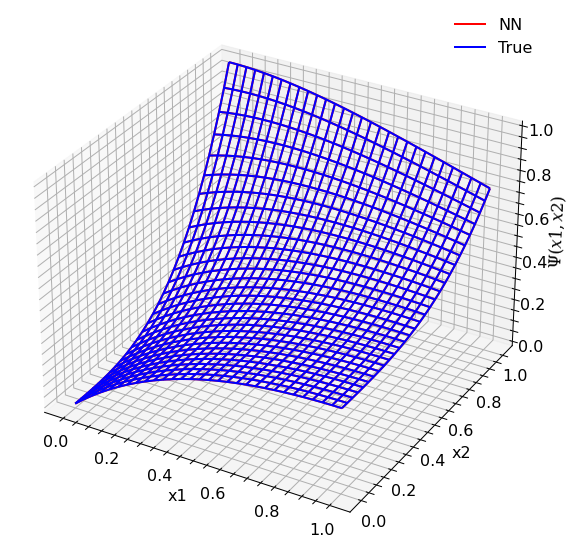

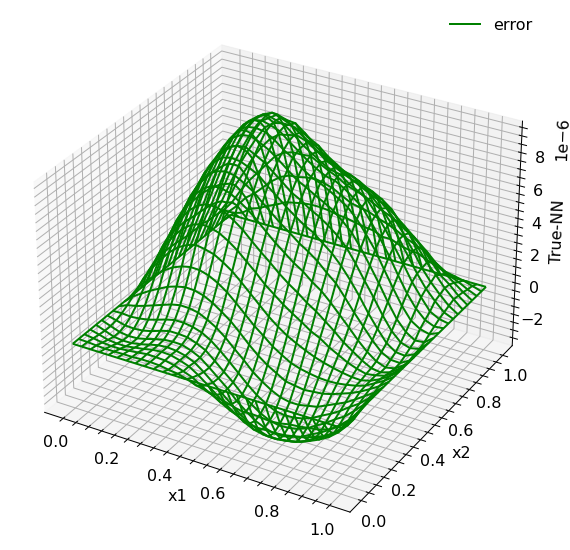

In [99]:
Data = np.load(path + "x1_x2_y.npz")
y_pred = Data['y'].reshape(30,30)


x1,x2 = torch.meshgrid(x_test1,x_test2)
y_true = (x1 +x2**3)*torch.exp(-x1)
y_err = y_true - y_pred


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(x1, x2, y_pred,label='NN',color='r')
ax.plot_wireframe(x1, x2, y_true,label='True',color='b')
ax.set(xlabel="x1",
       ylabel="x2",
       zlabel="$\Psi(x1,x2)$")
plt.legend()
plt.savefig(path + "solution.png",dpi=100)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='3d')
ax1.plot_wireframe(x1, x2, y_err,label='error',color='g')

ax1.set(xlabel="x1",
       ylabel="x2",
       zlabel="True-NN")
plt.legend()
plt.savefig(path + "Error.png",dpi=100,)

# P6:
$$∇^2Ψ(x, y) = e^\frac{−ax+y}{5} \{[−\frac{4}{5}a^3x −\frac{2}{5}+ 2a^2]cos(a^2x^2 + y) + [ \frac{1}{25}− 1 − 4a^4x^2 +\frac{a^2}{25}]sin(a
^2x^2 + y)\}$$

In [107]:
def phi(x,y):
    return torch.sin(9*x**2 + y) * torch.exp((-3*x+y)/5)

def f0(y):
    return phi(torch.zeros_like(y),y)
def f1(y):
    return phi(torch.ones_like(y),y)

def g0(x):
    return phi(x,torch.zeros_like(x))
def g1(x):
    return phi(x,torch.ones_like(x))

def eq1(x):
    return -0.8*27*x - 0.4 + 2 * 9


def A(x1,x2):
    return (1-x1) * f0(x2) + x1 * f1(x2) + (1-x2) * (g0(x1)-((1-x1)*g0(torch.zeros_like(x1)) + x1*g0(torch.ones_like(x1)))) +x2 * (g1(x1) - ((1-x1)*g1(torch.zeros_like(x1)) + x1 * g1(torch.ones_like(x1))))

In [108]:
def One_train(x1,x2,learning_rate,epochs,path,device):
    x1,x2 = torch.meshgrid(x1,x2)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)

    Net = SampleNet(2,8,30).to(device)
    opt = optim.Adam(Net.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net.apply(init_normal)
    Net.train()



    ########## loss
    def loss_a(x1,x2):
        x1.requires_grad = True
        x2.requires_grad = True
        input = torch.cat((x1,x2),1)
        phi_t = A(x1,x2) + x1*(1-x1)*x2*(1-x2)*Net(input)
    
        phit_x1 = torch.autograd.grad(phi_t,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x2 = torch.autograd.grad(phi_t,x2,grad_outputs=torch.ones_like(x2).to(device),create_graph=True)[0]
        phit_x11 = torch.autograd.grad(phit_x1,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x22 = torch.autograd.grad(phit_x2,x2,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]        
        f_x = (eq1(x1)*torch.cos(9*x1**2 + x2) + (1/25 - 1 - 4*3**4*x1**2 + 9/25)*torch.sin(9*x1**2 + x2))*torch.exp((-3*x1+x2)/5)
        loss = torch.sum((phit_x11 + phit_x22-f_x)**2)
  

        return loss

    tic = time.time()
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)


    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []
        Net.zero_grad()

        loss = loss_a(x1,x2)
        loss.backward()
        opt.step()
        Loss.append(loss.item())
        print('Train Epoch:{} Loss:{:.6f}'.format(epoch,loss.item()))
        Loss = np.array(Loss)
        if np.mean(Loss) < Loss_mean:
            checkpoint0 = {
                'epoch':epoch + 1,
                'state_dict':Net.state_dict(),
                'optimizer':opt.state_dict(),
                'loss':loss.item()
            }
            torch.save(checkpoint0,path+"model_One.pt")
            print("save model")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))


    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss_all.txt',np.array(Loss_list))



In [109]:
def One_test(x1,x2,path,device):
    Net = SampleNet(2,8,30).to(device)
    Net.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net.eval()

    x1,x2 = torch.meshgrid(x1,x2)
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)
    input = torch.cat((x1,x2),1)
    y_pred_t1 = A(x1,x2) + x1*(1-x1)*x2*(1-x2)*Net(input)
    print('Testing over')
    np.savez(path + 'x1_x2_y',x1 = x1.detach().numpy(),x2 = x2.detach().numpy(),y = y_pred_t1.detach().numpy())



In [127]:
epochs = 3000
path = "./p6/"
learning_rate = 1e-3

x_train1 = torch.linspace(0,1,10)
x_train2 = torch.linspace(0,1,10)

x_test1 = torch.linspace(0,1,30)
x_test2 = torch.linspace(0,1,30)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

One_train(x_train1,x_train2,learning_rate,epochs,path,device)
One_test(x_test1,x_test2,path,device)



Train Epoch:0 Loss:3472.019287
Train Epoch:1 Loss:3467.911133
Train Epoch:2 Loss:3464.395020
Train Epoch:3 Loss:3461.315674
Train Epoch:4 Loss:3458.518066
Train Epoch:5 Loss:3455.869629
Train Epoch:6 Loss:3453.250977
Train Epoch:7 Loss:3450.560059
Train Epoch:8 Loss:3447.703369
Train Epoch:9 Loss:3444.596924
Train Epoch:10 Loss:3441.156982
Train Epoch:11 Loss:3437.304932
Train Epoch:12 Loss:3432.973877
Train Epoch:13 Loss:3428.108154
Train Epoch:14 Loss:3422.651855
Train Epoch:15 Loss:3416.549316
Train Epoch:16 Loss:3409.665527
Train Epoch:17 Loss:3401.738281
Train Epoch:18 Loss:3392.316406
Train Epoch:19 Loss:3380.824219
Train Epoch:20 Loss:3366.675293
Train Epoch:21 Loss:3349.355713
Train Epoch:22 Loss:3328.451172
Train Epoch:23 Loss:3303.667969
Train Epoch:24 Loss:3274.822510
Train Epoch:25 Loss:3241.823242
Train Epoch:26 Loss:3204.541992
Train Epoch:27 Loss:3162.671875
Train Epoch:28 Loss:3115.776855
Train Epoch:29 Loss:3063.515137
Train Epoch:30 Loss:3005.875732
Train Epoch:31 Los

save model
Train Epoch:233 Loss:5.315812
save model
Train Epoch:234 Loss:5.262530
save model
Train Epoch:235 Loss:5.210342
save model
Train Epoch:236 Loss:5.159342
save model
Train Epoch:237 Loss:5.109397
save model
Train Epoch:238 Loss:5.060463
save model
Train Epoch:239 Loss:5.012578
save model
Train Epoch:240 Loss:4.965587
save model
Train Epoch:241 Loss:4.919486
save model
Train Epoch:242 Loss:4.874415
save model
Train Epoch:243 Loss:4.830158
save model
Train Epoch:244 Loss:4.786692
save model
Train Epoch:245 Loss:4.744140
save model
Train Epoch:246 Loss:4.702297
save model
Train Epoch:247 Loss:4.661229
save model
Train Epoch:248 Loss:4.620930
save model
Train Epoch:249 Loss:4.581442
save model
Train Epoch:250 Loss:4.542603
save model
Train Epoch:251 Loss:4.504510
save model
Train Epoch:252 Loss:4.467043
save model
Train Epoch:253 Loss:4.430341
save model
Train Epoch:254 Loss:4.394220
save model
Train Epoch:255 Loss:4.358797
save model
Train Epoch:256 Loss:4.323980
save model
Train

save model
Train Epoch:437 Loss:2.437555
save model
Train Epoch:438 Loss:2.434312
save model
Train Epoch:439 Loss:2.431060
save model
Train Epoch:440 Loss:2.427797
save model
Train Epoch:441 Loss:2.424542
save model
Train Epoch:442 Loss:2.421314
save model
Train Epoch:443 Loss:2.418079
save model
Train Epoch:444 Loss:2.414854
save model
Train Epoch:445 Loss:2.411633
save model
Train Epoch:446 Loss:2.408404
save model
Train Epoch:447 Loss:2.405194
save model
Train Epoch:448 Loss:2.401987
save model
Train Epoch:449 Loss:2.398794
save model
Train Epoch:450 Loss:2.395586
save model
Train Epoch:451 Loss:2.392393
save model
Train Epoch:452 Loss:2.389220
save model
Train Epoch:453 Loss:2.386037
save model
Train Epoch:454 Loss:2.382860
save model
Train Epoch:455 Loss:2.379681
save model
Train Epoch:456 Loss:2.376508
save model
Train Epoch:457 Loss:2.373355
save model
Train Epoch:458 Loss:2.370217
save model
Train Epoch:459 Loss:2.367085
save model
Train Epoch:460 Loss:2.364010
save model
Train

Train Epoch:679 Loss:1.923738
Train Epoch:680 Loss:1.918457
Train Epoch:681 Loss:1.869956
Train Epoch:682 Loss:1.855001
save model
Train Epoch:683 Loss:1.899144
Train Epoch:684 Loss:1.901936
Train Epoch:685 Loss:1.847577
save model
Train Epoch:686 Loss:1.838911
save model
Train Epoch:687 Loss:1.872980
Train Epoch:688 Loss:1.872902
Train Epoch:689 Loss:1.844265
Train Epoch:690 Loss:1.835231
save model
Train Epoch:691 Loss:1.842099
Train Epoch:692 Loss:1.843572
Train Epoch:693 Loss:1.842591
Train Epoch:694 Loss:1.838034
Train Epoch:695 Loss:1.825724
save model
Train Epoch:696 Loss:1.818044
save model
Train Epoch:697 Loss:1.824837
Train Epoch:698 Loss:1.832902
Train Epoch:699 Loss:1.826429
Train Epoch:700 Loss:1.813161
save model
Train Epoch:701 Loss:1.807922
save model
Train Epoch:702 Loss:1.810842
Train Epoch:703 Loss:1.812922
Train Epoch:704 Loss:1.811091
Train Epoch:705 Loss:1.809111
Train Epoch:706 Loss:1.807699
save model
Train Epoch:707 Loss:1.804243
save model
Train Epoch:708 Loss

Train Epoch:939 Loss:1.572313
save model
Train Epoch:940 Loss:1.591661
Train Epoch:941 Loss:1.591970
Train Epoch:942 Loss:1.572431
Train Epoch:943 Loss:1.571546
save model
Train Epoch:944 Loss:1.584435
Train Epoch:945 Loss:1.581668
Train Epoch:946 Loss:1.568672
save model
Train Epoch:947 Loss:1.568503
save model
Train Epoch:948 Loss:1.577197
Train Epoch:949 Loss:1.577144
Train Epoch:950 Loss:1.569943
Train Epoch:951 Loss:1.570461
Train Epoch:952 Loss:1.583067
Train Epoch:953 Loss:1.603387
Train Epoch:954 Loss:1.641927
Train Epoch:955 Loss:1.733635
Train Epoch:956 Loss:1.965847
Train Epoch:957 Loss:2.316664
Train Epoch:958 Loss:2.775094
Train Epoch:959 Loss:2.308743
Train Epoch:960 Loss:1.643425
Train Epoch:961 Loss:1.773105
Train Epoch:962 Loss:2.077748
Train Epoch:963 Loss:1.725811
Train Epoch:964 Loss:1.631709
Train Epoch:965 Loss:1.897578
Train Epoch:966 Loss:1.683384
Train Epoch:967 Loss:1.617519
Train Epoch:968 Loss:1.787603
Train Epoch:969 Loss:1.614159
Train Epoch:970 Loss:1.632

Train Epoch:1198 Loss:1.656082
Train Epoch:1199 Loss:1.658171
Train Epoch:1200 Loss:1.565913
Train Epoch:1201 Loss:1.690589
Train Epoch:1202 Loss:1.497000
Train Epoch:1203 Loss:1.661876
Train Epoch:1204 Loss:1.511679
Train Epoch:1205 Loss:1.577478
Train Epoch:1206 Loss:1.549711
Train Epoch:1207 Loss:1.527031
Train Epoch:1208 Loss:1.547265
Train Epoch:1209 Loss:1.521963
Train Epoch:1210 Loss:1.530837
Train Epoch:1211 Loss:1.508393
Train Epoch:1212 Loss:1.531018
Train Epoch:1213 Loss:1.489505
Train Epoch:1214 Loss:1.532832
Train Epoch:1215 Loss:1.491056
Train Epoch:1216 Loss:1.521792
Train Epoch:1217 Loss:1.509547
Train Epoch:1218 Loss:1.517027
Train Epoch:1219 Loss:1.533082
Train Epoch:1220 Loss:1.540410
Train Epoch:1221 Loss:1.581112
Train Epoch:1222 Loss:1.638776
Train Epoch:1223 Loss:1.718899
Train Epoch:1224 Loss:1.768186
Train Epoch:1225 Loss:1.852780
Train Epoch:1226 Loss:1.776309
Train Epoch:1227 Loss:1.645597
Train Epoch:1228 Loss:1.493716
Train Epoch:1229 Loss:1.498604
Train Ep

Train Epoch:1462 Loss:1.797078
Train Epoch:1463 Loss:1.673439
Train Epoch:1464 Loss:1.472608
Train Epoch:1465 Loss:1.450667
Train Epoch:1466 Loss:1.580323
Train Epoch:1467 Loss:1.632574
Train Epoch:1468 Loss:1.530071
Train Epoch:1469 Loss:1.430939
Train Epoch:1470 Loss:1.465929
Train Epoch:1471 Loss:1.550095
Train Epoch:1472 Loss:1.532952
Train Epoch:1473 Loss:1.445718
Train Epoch:1474 Loss:1.413283
save model
Train Epoch:1475 Loss:1.467221
Train Epoch:1476 Loss:1.507770
Train Epoch:1477 Loss:1.467309
Train Epoch:1478 Loss:1.414640
Train Epoch:1479 Loss:1.421775
Train Epoch:1480 Loss:1.466234
Train Epoch:1481 Loss:1.481218
Train Epoch:1482 Loss:1.462643
Train Epoch:1483 Loss:1.468629
Train Epoch:1484 Loss:1.537285
Train Epoch:1485 Loss:1.710736
Train Epoch:1486 Loss:1.863455
Train Epoch:1487 Loss:2.106129
Train Epoch:1488 Loss:1.797293
Train Epoch:1489 Loss:1.521116
Train Epoch:1490 Loss:1.557688
Train Epoch:1491 Loss:1.713137
Train Epoch:1492 Loss:1.610543
Train Epoch:1493 Loss:1.4351

Train Epoch:1729 Loss:1.394404
Train Epoch:1730 Loss:1.394323
Train Epoch:1731 Loss:1.394507
Train Epoch:1732 Loss:1.394750
Train Epoch:1733 Loss:1.396203
Train Epoch:1734 Loss:1.399194
Train Epoch:1735 Loss:1.405066
Train Epoch:1736 Loss:1.412137
Train Epoch:1737 Loss:1.421920
Train Epoch:1738 Loss:1.433348
Train Epoch:1739 Loss:1.451764
Train Epoch:1740 Loss:1.475710
Train Epoch:1741 Loss:1.514331
Train Epoch:1742 Loss:1.564424
Train Epoch:1743 Loss:1.632058
Train Epoch:1744 Loss:1.718783
Train Epoch:1745 Loss:1.807692
Train Epoch:1746 Loss:1.875782
Train Epoch:1747 Loss:1.903131
Train Epoch:1748 Loss:1.776049
Train Epoch:1749 Loss:1.592419
Train Epoch:1750 Loss:1.499835
Train Epoch:1751 Loss:1.544823
Train Epoch:1752 Loss:1.655254
Train Epoch:1753 Loss:1.652573
Train Epoch:1754 Loss:1.535105
Train Epoch:1755 Loss:1.425215
Train Epoch:1756 Loss:1.451160
Train Epoch:1757 Loss:1.544691
Train Epoch:1758 Loss:1.568371
Train Epoch:1759 Loss:1.493243
Train Epoch:1760 Loss:1.411467
Train Ep

Train Epoch:1996 Loss:1.394629
Train Epoch:1997 Loss:1.383727
Train Epoch:1998 Loss:1.397961
Train Epoch:1999 Loss:1.453807
Train Epoch:2000 Loss:1.525923
Train Epoch:2001 Loss:1.643015
Train Epoch:2002 Loss:1.971189
Train Epoch:2003 Loss:1.926357
Train Epoch:2004 Loss:1.695826
Train Epoch:2005 Loss:1.388134
Train Epoch:2006 Loss:1.554966
Train Epoch:2007 Loss:1.739151
Train Epoch:2008 Loss:1.443320
Train Epoch:2009 Loss:1.454928
Train Epoch:2010 Loss:1.638602
Train Epoch:2011 Loss:1.433905
Train Epoch:2012 Loss:1.460296
Train Epoch:2013 Loss:1.574326
Train Epoch:2014 Loss:1.389466
Train Epoch:2015 Loss:1.462904
Train Epoch:2016 Loss:1.516555
Train Epoch:2017 Loss:1.387403
Train Epoch:2018 Loss:1.485061
Train Epoch:2019 Loss:1.450986
Train Epoch:2020 Loss:1.370245
Train Epoch:2021 Loss:1.462147
Train Epoch:2022 Loss:1.400256
Train Epoch:2023 Loss:1.384973
Train Epoch:2024 Loss:1.445437
Train Epoch:2025 Loss:1.378051
Train Epoch:2026 Loss:1.407909
Train Epoch:2027 Loss:1.431808
Train Ep

Train Epoch:2264 Loss:1.449473
Train Epoch:2265 Loss:1.450187
Train Epoch:2266 Loss:1.400498
Train Epoch:2267 Loss:1.401154
Train Epoch:2268 Loss:1.474728
Train Epoch:2269 Loss:1.526082
Train Epoch:2270 Loss:1.558893
Train Epoch:2271 Loss:1.695855
Train Epoch:2272 Loss:1.830065
Train Epoch:2273 Loss:1.901750
Train Epoch:2274 Loss:1.707179
Train Epoch:2275 Loss:1.528775
Train Epoch:2276 Loss:1.426280
Train Epoch:2277 Loss:1.414773
Train Epoch:2278 Loss:1.502129
Train Epoch:2279 Loss:1.593678
Train Epoch:2280 Loss:1.540376
Train Epoch:2281 Loss:1.394613
Train Epoch:2282 Loss:1.352146
Train Epoch:2283 Loss:1.437552
Train Epoch:2284 Loss:1.500895
Train Epoch:2285 Loss:1.452295
Train Epoch:2286 Loss:1.374956
Train Epoch:2287 Loss:1.363602
Train Epoch:2288 Loss:1.396112
Train Epoch:2289 Loss:1.417066
Train Epoch:2290 Loss:1.415193
Train Epoch:2291 Loss:1.382720
Train Epoch:2292 Loss:1.355561
Train Epoch:2293 Loss:1.360773
Train Epoch:2294 Loss:1.383311
Train Epoch:2295 Loss:1.388989
Train Ep

Train Epoch:2533 Loss:1.342399
Train Epoch:2534 Loss:1.346711
Train Epoch:2535 Loss:1.362572
Train Epoch:2536 Loss:1.400922
Train Epoch:2537 Loss:1.463501
Train Epoch:2538 Loss:1.607156
Train Epoch:2539 Loss:1.707138
Train Epoch:2540 Loss:1.853000
Train Epoch:2541 Loss:1.523422
Train Epoch:2542 Loss:1.350847
Train Epoch:2543 Loss:1.454664
Train Epoch:2544 Loss:1.512994
Train Epoch:2545 Loss:1.424280
Train Epoch:2546 Loss:1.352980
Train Epoch:2547 Loss:1.444609
Train Epoch:2548 Loss:1.468772
Train Epoch:2549 Loss:1.346686
Train Epoch:2550 Loss:1.375926
Train Epoch:2551 Loss:1.442834
Train Epoch:2552 Loss:1.364680
Train Epoch:2553 Loss:1.362792
Train Epoch:2554 Loss:1.428936
Train Epoch:2555 Loss:1.387898
Train Epoch:2556 Loss:1.367772
Train Epoch:2557 Loss:1.419304
Train Epoch:2558 Loss:1.420772
Train Epoch:2559 Loss:1.407605
Train Epoch:2560 Loss:1.474730
Train Epoch:2561 Loss:1.547843
Train Epoch:2562 Loss:1.627809
Train Epoch:2563 Loss:1.729355
Train Epoch:2564 Loss:1.840537
Train Ep

Train Epoch:2803 Loss:1.342034
Train Epoch:2804 Loss:1.345163
Train Epoch:2805 Loss:1.351086
Train Epoch:2806 Loss:1.360353
Train Epoch:2807 Loss:1.374642
Train Epoch:2808 Loss:1.393270
Train Epoch:2809 Loss:1.426161
Train Epoch:2810 Loss:1.474264
Train Epoch:2811 Loss:1.552522
Train Epoch:2812 Loss:1.636893
Train Epoch:2813 Loss:1.725177
Train Epoch:2814 Loss:1.708957
Train Epoch:2815 Loss:1.611986
Train Epoch:2816 Loss:1.449278
Train Epoch:2817 Loss:1.371772
Train Epoch:2818 Loss:1.451622
Train Epoch:2819 Loss:1.615686
Train Epoch:2820 Loss:1.726231
Train Epoch:2821 Loss:1.698367
Train Epoch:2822 Loss:1.566808
Train Epoch:2823 Loss:1.437734
Train Epoch:2824 Loss:1.463928
Train Epoch:2825 Loss:1.536574
Train Epoch:2826 Loss:1.520172
Train Epoch:2827 Loss:1.428888
Train Epoch:2828 Loss:1.371845
Train Epoch:2829 Loss:1.416277
Train Epoch:2830 Loss:1.482403
Train Epoch:2831 Loss:1.461540
Train Epoch:2832 Loss:1.383081
Train Epoch:2833 Loss:1.336384
Train Epoch:2834 Loss:1.368601
Train Ep

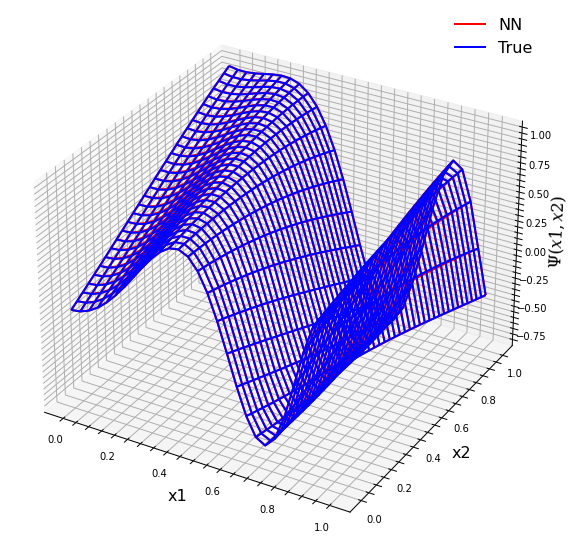

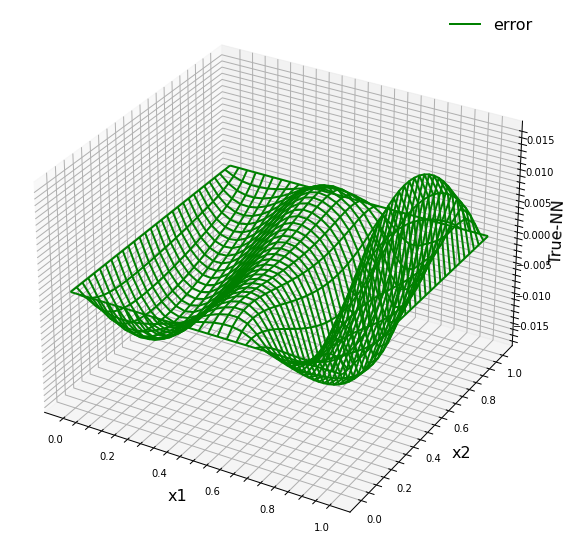

In [128]:
Data = np.load(path + "x1_x2_y.npz")
y_pred = Data['y'].reshape(30,30)

x1,x2 = torch.meshgrid(x_test1,x_test2)
y_true = torch.sin(9*x1**2 + x2)*torch.exp((-3*x1 + x2)/5)
y_err = y_true - y_pred



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.tick_params(labelsize=10)
ax.plot_wireframe(x1, x2, y_pred,label='NN',color='r')
ax.plot_wireframe(x1, x2, y_true,label='True',color='b')
ax.set(xlabel="x1",
       ylabel="x2",
       zlabel="$\Psi(x1,x2)$"
      )
plt.legend()
plt.savefig(path + "solution.png",dpi=100)


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='3d')
ax1.tick_params(labelsize=10)
ax1.plot_wireframe(x1, x2, y_err,label='error',color='g')
ax1.set(xlabel="x1",
       ylabel="x2",
       zlabel="True-NN")
plt.legend()
plt.savefig(path + "Error.png",dpi=100)

# P7:$$∇^2Ψ(x, y) = (2 − π^2y^2)sin(πx)$$


In [129]:
def phi(x,y):
    return y**2*torch.sin(math.pi*x)

def f0(y):
    return phi(torch.zeros_like(y),y)
def f1(y):
    return phi(torch.ones_like(y),y)

def g0(x):
    return phi(x,torch.zeros_like(x))

def g1(x):
    return 2*torch.sin(math.pi*x)

def pa1(x1,x2):
    return (torch.ones_like(x1))*f0(x2)
def pa2(x1,x2):
    return x1 * f1(x2)
def pa3(x1,x2):
    return (1 - x1) * g0(torch.zeros_like(x2)) + x1*g0(torch.ones_like(x2))
def pa4(x1,x2):
    return x2*(g1(x1) -(torch.ones_like(x1) - x1)*g1(torch.zeros_like(x1)) + x1*g1(torch.ones_like(x1)))

def B(x1,x2):
    return pa1(x1,x2) + pa2(x1,x2) + g0(x1) - pa3(x1,x2) + pa4(x1,x2)

In [130]:
def One_train(x1,x2,x3,x4,learning_rate,epochs,path,device):
    x1,x2 = torch.meshgrid(x1,x2)
    x3,x4 = torch.meshgrid(x3,x4)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    x3 = x3.reshape(-1,1)
    x4 = x4.reshape(-1,1)

    # print(torch.cat(x1,x3))

    Net = SampleNet(2,8,30).to(device)
    opt = optim.Adam(Net.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net.apply(init_normal)
    Net.train()



    ########## loss
    def loss_a(x1,x2,x3,x4):
        x1.requires_grad = True
        x2.requires_grad = True
        x3.requires_grad = True
        x4.requires_grad = True
        input = torch.cat((x1,x2),1)
        input1 = torch.cat((x3,x4),1)
        # print(input1)
        Net_y = torch.autograd.grad(Net(input1),x4,grad_outputs=torch.ones_like(x4).to(device),create_graph=True)[0]
        
        phi_t = B(x1,x2) + x1*(torch.ones_like(x1)-x1)*x2*(Net(input) - Net(input1) - Net_y)
    
        phit_x1 = torch.autograd.grad(phi_t,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x2 = torch.autograd.grad(phi_t,x2,grad_outputs=torch.ones_like(x2).to(device),create_graph=True)[0]
        phit_x11 = torch.autograd.grad(phit_x1,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x22 = torch.autograd.grad(phit_x2,x2,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]        
        f_x = (2-math.pi**2*x2**2)*torch.sin(math.pi*x1)
        loss = torch.sum((phit_x11 + phit_x22-f_x)**2)
  

        return loss

    tic = time.time()
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)


    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []
        Net.zero_grad()

        loss = loss_a(x1,x2,x3,x4)
        loss.backward()
        opt.step()
        Loss.append(loss.item())
        print('Train Epoch:{} Loss:{:.6f}'.format(epoch,loss.item()))
        Loss = np.array(Loss)
        if np.mean(Loss) < Loss_mean:
            checkpoint0 = {
                'epoch':epoch + 1,
                'state_dict':Net.state_dict(),
                'optimizer':opt.state_dict(),
                'loss':loss.item()
            }
            torch.save(checkpoint0,path+"model_One.pt")
            print("save model")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))


    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss_all.txt',np.array(Loss_list))

In [131]:
def One_test(x1,x2,x3,x4,path,device):
    x1.requires_grad = True
    x2.requires_grad = True
    x3.requires_grad = True
    x4.requires_grad = True

    Net = SampleNet(2,8,30).to(device)
    Net.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net.eval()

    x1,x2 = torch.meshgrid(x1,x2)
    x3,x4 = torch.meshgrid(x3,x4)
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)
    x3 = torch.FloatTensor(x3).reshape(-1,1).to(device)
    x4 = torch.FloatTensor(x4).reshape(-1,1).to(device)

    input = torch.cat((x1,x2),1)
    input1 = torch.cat((x3,x4),1)

    Net_y = torch.autograd.grad(Net(input1),x4,grad_outputs=torch.ones_like(x4).to(device),create_graph=True)[0]

    y_pred_t1 = B(x1,x2) + x1*(torch.ones_like(x1)-x1)*x2*(Net(input) - Net(input1) - Net_y)
    print('Testing over')
    np.savez(path + 'x1_x2_y',x1 = x1.detach().numpy(),x2 = x2.detach().numpy(),y = y_pred_t1.detach().numpy())




In [132]:
epochs = 3000
path = "./p7/"
learning_rate = 0.001

x_train1 = torch.linspace(0,1,10)
x_train2 = torch.linspace(0,1,10)
x_train3 = torch.linspace(0,1,10)
x_train4 = torch.linspace(1,1,10)



x_test1 = torch.linspace(0,1,30)
x_test2 = torch.linspace(0,1,30)
x_test3 = torch.linspace(0,1,30)
x_test4 = torch.linspace(1,1,30)





device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

One_train(x_train1,x_train2,x_train3,x_train4,learning_rate,epochs,path,device)
One_test(x_test1,x_test2,x_test3,x_test4,path,device)



Train Epoch:0 Loss:3982.559570
Train Epoch:1 Loss:3871.610107
Train Epoch:2 Loss:3777.976074
Train Epoch:3 Loss:3697.205811
Train Epoch:4 Loss:3625.770752
Train Epoch:5 Loss:3560.684570
Train Epoch:6 Loss:3499.333008
Train Epoch:7 Loss:3439.367676
Train Epoch:8 Loss:3378.604004
Train Epoch:9 Loss:3314.932129
Train Epoch:10 Loss:3246.289062
Train Epoch:11 Loss:3170.692871
Train Epoch:12 Loss:3086.281250
Train Epoch:13 Loss:2991.322754
Train Epoch:14 Loss:2884.219727
Train Epoch:15 Loss:2763.517090
Train Epoch:16 Loss:2627.935791
Train Epoch:17 Loss:2476.427490
Train Epoch:18 Loss:2308.261719
Train Epoch:19 Loss:2123.182129
Train Epoch:20 Loss:1921.660889
Train Epoch:21 Loss:1705.298340
Train Epoch:22 Loss:1477.425171
Train Epoch:23 Loss:1243.940552
Train Epoch:24 Loss:1014.357178
Train Epoch:25 Loss:802.801941
Train Epoch:26 Loss:628.182556
Train Epoch:27 Loss:511.278229
Train Epoch:28 Loss:464.709473
Train Epoch:29 Loss:475.330292
Train Epoch:30 Loss:497.297424
Train Epoch:31 Loss:484.

save model
Train Epoch:222 Loss:1.033239
save model
Train Epoch:223 Loss:1.017530
save model
Train Epoch:224 Loss:1.002280
save model
Train Epoch:225 Loss:0.987468
save model
Train Epoch:226 Loss:0.973082
save model
Train Epoch:227 Loss:0.959106
save model
Train Epoch:228 Loss:0.945520
save model
Train Epoch:229 Loss:0.932310
save model
Train Epoch:230 Loss:0.919467
save model
Train Epoch:231 Loss:0.906977
save model
Train Epoch:232 Loss:0.894815
save model
Train Epoch:233 Loss:0.882983
save model
Train Epoch:234 Loss:0.871452
save model
Train Epoch:235 Loss:0.860227
save model
Train Epoch:236 Loss:0.849290
save model
Train Epoch:237 Loss:0.838629
save model
Train Epoch:238 Loss:0.828228
save model
Train Epoch:239 Loss:0.818085
save model
Train Epoch:240 Loss:0.808190
save model
Train Epoch:241 Loss:0.798528
save model
Train Epoch:242 Loss:0.789097
save model
Train Epoch:243 Loss:0.779887
save model
Train Epoch:244 Loss:0.770884
save model
Train Epoch:245 Loss:0.762080
save model
Train

save model
Train Epoch:422 Loss:0.210846
save model
Train Epoch:423 Loss:0.209742
save model
Train Epoch:424 Loss:0.208648
save model
Train Epoch:425 Loss:0.207556
save model
Train Epoch:426 Loss:0.206473
save model
Train Epoch:427 Loss:0.205398
save model
Train Epoch:428 Loss:0.204327
save model
Train Epoch:429 Loss:0.203264
save model
Train Epoch:430 Loss:0.202205
save model
Train Epoch:431 Loss:0.201154
save model
Train Epoch:432 Loss:0.200108
save model
Train Epoch:433 Loss:0.199072
save model
Train Epoch:434 Loss:0.198037
save model
Train Epoch:435 Loss:0.197012
save model
Train Epoch:436 Loss:0.195990
save model
Train Epoch:437 Loss:0.194975
save model
Train Epoch:438 Loss:0.193964
save model
Train Epoch:439 Loss:0.192959
save model
Train Epoch:440 Loss:0.191961
save model
Train Epoch:441 Loss:0.190966
save model
Train Epoch:442 Loss:0.189979
save model
Train Epoch:443 Loss:0.188994
save model
Train Epoch:444 Loss:0.188017
save model
Train Epoch:445 Loss:0.187045
save model
Train

save model
Train Epoch:630 Loss:0.061051
save model
Train Epoch:631 Loss:0.060661
save model
Train Epoch:632 Loss:0.060396
save model
Train Epoch:633 Loss:0.060622
Train Epoch:634 Loss:0.062868
Train Epoch:635 Loss:0.073543
Train Epoch:636 Loss:0.119891
Train Epoch:637 Loss:0.299874
Train Epoch:638 Loss:0.859452
Train Epoch:639 Loss:1.475593
Train Epoch:640 Loss:1.013902
Train Epoch:641 Loss:0.057403
save model
Train Epoch:642 Loss:0.830617
Train Epoch:643 Loss:0.838440
Train Epoch:644 Loss:0.059889
Train Epoch:645 Loss:0.790200
Train Epoch:646 Loss:0.444267
Train Epoch:647 Loss:0.173391
Train Epoch:648 Loss:0.684483
Train Epoch:649 Loss:0.107981
Train Epoch:650 Loss:0.380655
Train Epoch:651 Loss:0.338327
Train Epoch:652 Loss:0.090921
Train Epoch:653 Loss:0.399674
Train Epoch:654 Loss:0.074096
Train Epoch:655 Loss:0.260335
Train Epoch:656 Loss:0.203505
Train Epoch:657 Loss:0.094154
Train Epoch:658 Loss:0.265891
Train Epoch:659 Loss:0.059049
Train Epoch:660 Loss:0.190250
Train Epoch:661

save model
Train Epoch:871 Loss:0.016811
save model
Train Epoch:872 Loss:0.016640
save model
Train Epoch:873 Loss:0.016472
save model
Train Epoch:874 Loss:0.016334
save model
Train Epoch:875 Loss:0.016232
save model
Train Epoch:876 Loss:0.016159
save model
Train Epoch:877 Loss:0.016103
save model
Train Epoch:878 Loss:0.016055
save model
Train Epoch:879 Loss:0.016014
save model
Train Epoch:880 Loss:0.015986
save model
Train Epoch:881 Loss:0.015982
save model
Train Epoch:882 Loss:0.016025
Train Epoch:883 Loss:0.016164
Train Epoch:884 Loss:0.016486
Train Epoch:885 Loss:0.017185
Train Epoch:886 Loss:0.018653
Train Epoch:887 Loss:0.021835
Train Epoch:888 Loss:0.028738
Train Epoch:889 Loss:0.044555
Train Epoch:890 Loss:0.080016
Train Epoch:891 Loss:0.163433
Train Epoch:892 Loss:0.332053
Train Epoch:893 Loss:0.647114
Train Epoch:894 Loss:0.872114
Train Epoch:895 Loss:0.735196
Train Epoch:896 Loss:0.154354
Train Epoch:897 Loss:0.074416
Train Epoch:898 Loss:0.463535
Train Epoch:899 Loss:0.42254

Train Epoch:1133 Loss:0.006373
Train Epoch:1134 Loss:0.008491
Train Epoch:1135 Loss:0.013824
Train Epoch:1136 Loss:0.027902
Train Epoch:1137 Loss:0.064846
Train Epoch:1138 Loss:0.165660
Train Epoch:1139 Loss:0.405810
Train Epoch:1140 Loss:0.912371
Train Epoch:1141 Loss:1.249296
Train Epoch:1142 Loss:0.864949
Train Epoch:1143 Loss:0.045880
Train Epoch:1144 Loss:0.382942
Train Epoch:1145 Loss:0.828432
Train Epoch:1146 Loss:0.181329
Train Epoch:1147 Loss:0.156275
Train Epoch:1148 Loss:0.585409
Train Epoch:1149 Loss:0.147346
Train Epoch:1150 Loss:0.121959
Train Epoch:1151 Loss:0.421104
Train Epoch:1152 Loss:0.077319
Train Epoch:1153 Loss:0.132289
Train Epoch:1154 Loss:0.304245
Train Epoch:1155 Loss:0.028198
Train Epoch:1156 Loss:0.148459
Train Epoch:1157 Loss:0.210389
Train Epoch:1158 Loss:0.008060
Train Epoch:1159 Loss:0.153615
Train Epoch:1160 Loss:0.134502
Train Epoch:1161 Loss:0.008361
Train Epoch:1162 Loss:0.142769
Train Epoch:1163 Loss:0.078361
Train Epoch:1164 Loss:0.017062
Train Ep

Train Epoch:1398 Loss:0.002199
save model
Train Epoch:1399 Loss:0.018231
Train Epoch:1400 Loss:0.026324
Train Epoch:1401 Loss:0.008026
Train Epoch:1402 Loss:0.004530
Train Epoch:1403 Loss:0.018236
Train Epoch:1404 Loss:0.016148
Train Epoch:1405 Loss:0.003628
Train Epoch:1406 Loss:0.005989
Train Epoch:1407 Loss:0.014610
Train Epoch:1408 Loss:0.010611
Train Epoch:1409 Loss:0.002690
Train Epoch:1410 Loss:0.005031
Train Epoch:1411 Loss:0.010777
Train Epoch:1412 Loss:0.008480
Train Epoch:1413 Loss:0.002733
Train Epoch:1414 Loss:0.003293
Train Epoch:1415 Loss:0.007570
Train Epoch:1416 Loss:0.007528
Train Epoch:1417 Loss:0.003671
Train Epoch:1418 Loss:0.002085
save model
Train Epoch:1419 Loss:0.004267
Train Epoch:1420 Loss:0.006172
Train Epoch:1421 Loss:0.005062
Train Epoch:1422 Loss:0.002752
Train Epoch:1423 Loss:0.002068
save model
Train Epoch:1424 Loss:0.003341
Train Epoch:1425 Loss:0.004651
Train Epoch:1426 Loss:0.004430
Train Epoch:1427 Loss:0.003079
Train Epoch:1428 Loss:0.002016
save m

Train Epoch:1667 Loss:0.015170
Train Epoch:1668 Loss:0.020297
Train Epoch:1669 Loss:0.012344
Train Epoch:1670 Loss:0.002899
Train Epoch:1671 Loss:0.003325
Train Epoch:1672 Loss:0.010360
Train Epoch:1673 Loss:0.013780
Train Epoch:1674 Loss:0.010104
Train Epoch:1675 Loss:0.004034
Train Epoch:1676 Loss:0.001883
Train Epoch:1677 Loss:0.004484
Train Epoch:1678 Loss:0.008090
Train Epoch:1679 Loss:0.009165
Train Epoch:1680 Loss:0.007093
Train Epoch:1681 Loss:0.004074
Train Epoch:1682 Loss:0.002249
Train Epoch:1683 Loss:0.002395
Train Epoch:1684 Loss:0.003792
Train Epoch:1685 Loss:0.005246
Train Epoch:1686 Loss:0.005993
Train Epoch:1687 Loss:0.005886
Train Epoch:1688 Loss:0.005351
Train Epoch:1689 Loss:0.004757
Train Epoch:1690 Loss:0.004455
Train Epoch:1691 Loss:0.004492
Train Epoch:1692 Loss:0.004861
Train Epoch:1693 Loss:0.005372
Train Epoch:1694 Loss:0.005901
Train Epoch:1695 Loss:0.006219
Train Epoch:1696 Loss:0.006390
Train Epoch:1697 Loss:0.006587
Train Epoch:1698 Loss:0.007560
Train Ep

Train Epoch:1935 Loss:0.007828
Train Epoch:1936 Loss:0.013240
Train Epoch:1937 Loss:0.023310
Train Epoch:1938 Loss:0.043836
Train Epoch:1939 Loss:0.083982
Train Epoch:1940 Loss:0.165565
Train Epoch:1941 Loss:0.295874
Train Epoch:1942 Loss:0.479741
Train Epoch:1943 Loss:0.516894
Train Epoch:1944 Loss:0.337865
Train Epoch:1945 Loss:0.049962
Train Epoch:1946 Loss:0.039723
Train Epoch:1947 Loss:0.240598
Train Epoch:1948 Loss:0.272076
Train Epoch:1949 Loss:0.094078
Train Epoch:1950 Loss:0.004168
Train Epoch:1951 Loss:0.125141
Train Epoch:1952 Loss:0.192868
Train Epoch:1953 Loss:0.069439
Train Epoch:1954 Loss:0.003235
Train Epoch:1955 Loss:0.087800
Train Epoch:1956 Loss:0.123025
Train Epoch:1957 Loss:0.043234
Train Epoch:1958 Loss:0.003230
Train Epoch:1959 Loss:0.062015
Train Epoch:1960 Loss:0.086586
Train Epoch:1961 Loss:0.027852
Train Epoch:1962 Loss:0.003122
Train Epoch:1963 Loss:0.043886
Train Epoch:1964 Loss:0.058341
Train Epoch:1965 Loss:0.021571
Train Epoch:1966 Loss:0.001606
Train Ep

Train Epoch:2200 Loss:0.001606
Train Epoch:2201 Loss:0.001113
Train Epoch:2202 Loss:0.001930
Train Epoch:2203 Loss:0.002826
Train Epoch:2204 Loss:0.004187
Train Epoch:2205 Loss:0.005835
Train Epoch:2206 Loss:0.007141
Train Epoch:2207 Loss:0.008581
Train Epoch:2208 Loss:0.010800
Train Epoch:2209 Loss:0.013540
Train Epoch:2210 Loss:0.017945
Train Epoch:2211 Loss:0.025098
Train Epoch:2212 Loss:0.037433
Train Epoch:2213 Loss:0.056850
Train Epoch:2214 Loss:0.090807
Train Epoch:2215 Loss:0.138919
Train Epoch:2216 Loss:0.208517
Train Epoch:2217 Loss:0.259945
Train Epoch:2218 Loss:0.272463
Train Epoch:2219 Loss:0.179905
Train Epoch:2220 Loss:0.060071
Train Epoch:2221 Loss:0.001274
Train Epoch:2222 Loss:0.040348
Train Epoch:2223 Loss:0.117256
Train Epoch:2224 Loss:0.140606
Train Epoch:2225 Loss:0.093233
Train Epoch:2226 Loss:0.021222
Train Epoch:2227 Loss:0.003273
Train Epoch:2228 Loss:0.042621
Train Epoch:2229 Loss:0.081802
Train Epoch:2230 Loss:0.078425
Train Epoch:2231 Loss:0.035269
Train Ep

Train Epoch:2474 Loss:0.013592
Train Epoch:2475 Loss:0.007356
Train Epoch:2476 Loss:0.001851
Train Epoch:2477 Loss:0.001547
Train Epoch:2478 Loss:0.005380
Train Epoch:2479 Loss:0.009199
Train Epoch:2480 Loss:0.010060
Train Epoch:2481 Loss:0.007663
Train Epoch:2482 Loss:0.004180
Train Epoch:2483 Loss:0.001627
Train Epoch:2484 Loss:0.001015
Train Epoch:2485 Loss:0.002125
Train Epoch:2486 Loss:0.004111
Train Epoch:2487 Loss:0.006141
Train Epoch:2488 Loss:0.007632
Train Epoch:2489 Loss:0.008584
Train Epoch:2490 Loss:0.009007
Train Epoch:2491 Loss:0.009311
Train Epoch:2492 Loss:0.009572
Train Epoch:2493 Loss:0.010245
Train Epoch:2494 Loss:0.011449
Train Epoch:2495 Loss:0.013867
Train Epoch:2496 Loss:0.017921
Train Epoch:2497 Loss:0.025329
Train Epoch:2498 Loss:0.037606
Train Epoch:2499 Loss:0.059838
Train Epoch:2500 Loss:0.094901
Train Epoch:2501 Loss:0.153284
Train Epoch:2502 Loss:0.220720
Train Epoch:2503 Loss:0.287673
Train Epoch:2504 Loss:0.266027
Train Epoch:2505 Loss:0.165485
Train Ep

Train Epoch:2747 Loss:0.007638
Train Epoch:2748 Loss:0.010102
Train Epoch:2749 Loss:0.014376
Train Epoch:2750 Loss:0.021576
Train Epoch:2751 Loss:0.034854
Train Epoch:2752 Loss:0.057674
Train Epoch:2753 Loss:0.099698
Train Epoch:2754 Loss:0.163260
Train Epoch:2755 Loss:0.257284
Train Epoch:2756 Loss:0.319164
Train Epoch:2757 Loss:0.307442
Train Epoch:2758 Loss:0.155578
Train Epoch:2759 Loss:0.019768
Train Epoch:2760 Loss:0.020168
Train Epoch:2761 Loss:0.118976
Train Epoch:2762 Loss:0.179672
Train Epoch:2763 Loss:0.111939
Train Epoch:2764 Loss:0.017849
Train Epoch:2765 Loss:0.011945
Train Epoch:2766 Loss:0.077634
Train Epoch:2767 Loss:0.110267
Train Epoch:2768 Loss:0.059900
Train Epoch:2769 Loss:0.005703
Train Epoch:2770 Loss:0.014355
Train Epoch:2771 Loss:0.057280
Train Epoch:2772 Loss:0.068384
Train Epoch:2773 Loss:0.032078
Train Epoch:2774 Loss:0.002222
Train Epoch:2775 Loss:0.012069
Train Epoch:2776 Loss:0.038669
Train Epoch:2777 Loss:0.044444
Train Epoch:2778 Loss:0.022523
Train Ep

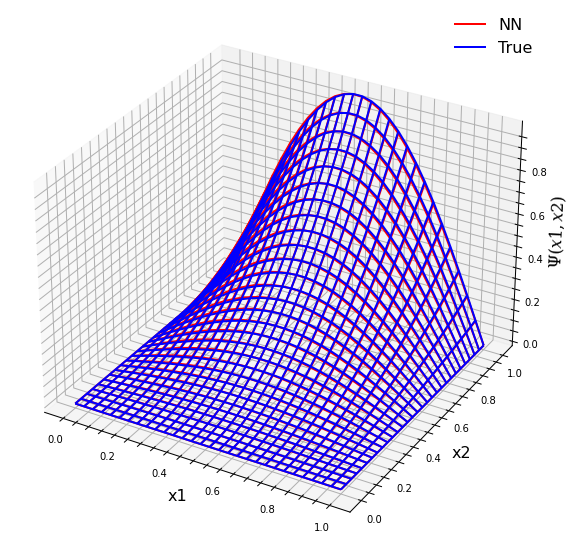

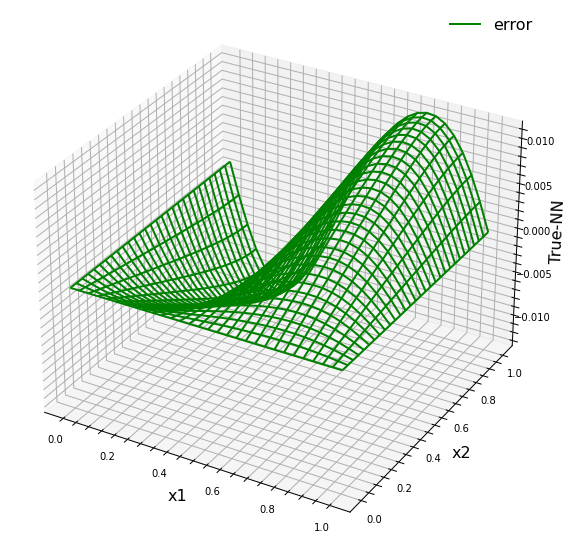

In [135]:
Data = np.load(path + "x1_x2_y.npz")
y_pred = Data['y'].reshape(30,30)
y_pred = torch.tensor(y_pred)

x1,x2 = torch.meshgrid(x_test1,x_test2)
y_true = x2**2*torch.sin(math.pi*x1)
y_err = y_true - y_pred

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.tick_params(labelsize=10)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), y_pred.detach().numpy(),label='NN',color='r')
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), y_true.detach().numpy(),label='True',color='b')
ax.set(xlabel="x1",
       ylabel="x2",
       zlabel="$\Psi(x1,x2)$"
      )
plt.legend()
plt.savefig(path + "solution.png",dpi=100)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='3d')
ax1.tick_params(labelsize=10)
ax1.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), y_err.detach().numpy(),label='error',color='g')
ax1.set(xlabel="x1",
       ylabel="x2",
       zlabel="True-NN"
      )
plt.legend()
plt.savefig(path + "Error.png",dpi=100)




# P8: $$∇^2Ψ(x, y) + Ψ(x, y)\frac{∂}{∂y}Ψ(x, y) = sin(πx)(2 − π^2y^2 + 2y^3sin(πx))$$

In [136]:
def phi(x,y):
    return y**2*torch.sin(math.pi*x)

def f0(y):
    return phi(torch.zeros_like(y),y)
def f1(y):
    return phi(torch.ones_like(y),y)

def g0(x):
    return phi(x,torch.zeros_like(x))

def g1(x):
    return 2*torch.sin(math.pi*x)

def pa1(x1,x2):
    return (torch.ones_like(x1))*f0(x2)
def pa2(x1,x2):
    return x1 * f1(x2)
def pa3(x1,x2):
    return (1 - x1) * g0(torch.zeros_like(x2)) + x1*g0(torch.ones_like(x2))
def pa4(x1,x2):
    return x2*(g1(x1) -(torch.ones_like(x1) - x1)*g1(torch.zeros_like(x1)) + x1*g1(torch.ones_like(x1)))

def B(x1,x2):
    return pa1(x1,x2) + pa2(x1,x2) + g0(x1) - pa3(x1,x2) + pa4(x1,x2)

In [137]:
def One_train(x1,x2,x3,x4,learning_rate,epochs,path,device):
    x1,x2 = torch.meshgrid(x1,x2)
    x3,x4 = torch.meshgrid(x3,x4)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    x3 = x3.reshape(-1,1)
    x4 = x4.reshape(-1,1)

    # print(torch.cat(x1,x3))

    Net = SampleNet(2,8,30).to(device)
    opt = optim.Adam(Net.parameters(),lr = learning_rate,betas=(0.9,0.99))
    
    def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    Net.apply(init_normal)
    Net.train()



    ########## loss
    def loss_a(x1,x2,x3,x4):
        x1.requires_grad = True
        x2.requires_grad = True
        x3.requires_grad = True
        x4.requires_grad = True
        input = torch.cat((x1,x2),1)
        input1 = torch.cat((x3,x4),1)
        # print(input1)
        Net_y = torch.autograd.grad(Net(input1),x4,grad_outputs=torch.ones_like(x4).to(device),create_graph=True)[0]
        
        phi_t = B(x1,x2) + x1*(torch.ones_like(x1)-x1)*x2*(Net(input) - Net(input1) - Net_y)
    
        phit_x1 = torch.autograd.grad(phi_t,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x2 = torch.autograd.grad(phi_t,x2,grad_outputs=torch.ones_like(x2).to(device),create_graph=True)[0]
        phit_x11 = torch.autograd.grad(phit_x1,x1,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]
        phit_x22 = torch.autograd.grad(phit_x2,x2,grad_outputs=torch.ones_like(x1).to(device),create_graph=True)[0]        
        f_x = (2-math.pi**2*x2**2 + 2*x2**3*torch.sin(math.pi* x1))*torch.sin(math.pi*x1) - phi_t * phit_x2
        loss = torch.sum((phit_x11 + phit_x22-f_x)**2)
  

        return loss

    tic = time.time()
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)


    Loss_list = []
    Loss_mean = 100

    for epoch in range(epochs):
        Loss = []
        Net.zero_grad()

        loss = loss_a(x1,x2,x3,x4)
        loss.backward()
        opt.step()
        Loss.append(loss.item())
        print('Train Epoch:{} Loss:{:.6f}'.format(epoch,loss.item()))
        Loss = np.array(Loss)
        print(Loss)
        print(np.mean(Loss))
        if np.mean(Loss) < Loss_mean:
            checkpoint0 = {
                'epoch':epoch + 1,
                'state_dict':Net.state_dict(),
                'optimizer':opt.state_dict(),
                'loss':loss.item()
            }
            torch.save(checkpoint0,path+"model_One.pt")
            print("save model")
            Loss_mean = np.mean(Loss)
        Loss_list.append(np.mean(Loss))


    toc = time.time()
    elapseTime = toc - tic
    print("elapse time in parallel = ", elapseTime)
    np.save(path + 'Loss_all.txt',np.array(Loss_list))

In [138]:
def One_test(x1,x2,x3,x4,path,device):
    x1.requires_grad = True
    x2.requires_grad = True
    x3.requires_grad = True
    x4.requires_grad = True

    Net = SampleNet(2,8,30).to(device)
    Net.load_state_dict(torch.load(path+"model_One.pt",map_location=device)['state_dict'])
    Net.eval()

    x1,x2 = torch.meshgrid(x1,x2)
    x3,x4 = torch.meshgrid(x3,x4)
    x1 = torch.FloatTensor(x1).reshape(-1,1).to(device)
    x2 = torch.FloatTensor(x2).reshape(-1,1).to(device)
    x3 = torch.FloatTensor(x3).reshape(-1,1).to(device)
    x4 = torch.FloatTensor(x4).reshape(-1,1).to(device)

    input = torch.cat((x1,x2),1)
    input1 = torch.cat((x3,x4),1)

    Net_y = torch.autograd.grad(Net(input1),x4,grad_outputs=torch.ones_like(x4).to(device),create_graph=True)[0]

    y_pred_t1 = B(x1,x2) + x1*(torch.ones_like(x1)-x1)*x2*(Net(input) - Net(input1) - Net_y)
    print('Testing over')
    np.savez(path + 'x1_x2_y',x1 = x1.detach().numpy(),x2 = x2.detach().numpy(),y = y_pred_t1.detach().numpy())

In [143]:
epochs = 3000
path = "./p8/"
learning_rate = 0.001

x_train1 = torch.linspace(0,1,10)
x_train2 = torch.linspace(0,1,10)
x_train3 = torch.linspace(0,1,10)
x_train4 = torch.linspace(1,1,10)

x_test1 = torch.linspace(0,1,30)
x_test2 = torch.linspace(0,1,30)
x_test3 = torch.linspace(0,1,30)
x_test4 = torch.linspace(1,1,30)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

One_train(x_train1,x_train2,x_train3,x_train4,learning_rate,epochs,path,device)
One_test(x_test1,x_test2,x_test3,x_test4,path,device)

Train Epoch:0 Loss:2066.492188
Train Epoch:1 Loss:1885.739746
Train Epoch:2 Loss:1698.821899
Train Epoch:3 Loss:1507.862305
Train Epoch:4 Loss:1319.972046
Train Epoch:5 Loss:1148.054688
Train Epoch:6 Loss:1011.160034
Train Epoch:7 Loss:932.151001
Train Epoch:8 Loss:926.861084
Train Epoch:9 Loss:975.588135
Train Epoch:10 Loss:1011.017883
Train Epoch:11 Loss:992.382996
Train Epoch:12 Loss:932.503174
Train Epoch:13 Loss:860.641174
Train Epoch:14 Loss:799.387451
Train Epoch:15 Loss:758.636963
Train Epoch:16 Loss:737.285156
Train Epoch:17 Loss:727.801392
Train Epoch:18 Loss:721.130005
Train Epoch:19 Loss:710.200745
Train Epoch:20 Loss:691.268982
Train Epoch:21 Loss:663.614136
Train Epoch:22 Loss:628.650452
Train Epoch:23 Loss:589.077698
Train Epoch:24 Loss:548.192139
Train Epoch:25 Loss:509.246826
Train Epoch:26 Loss:474.728851
Train Epoch:27 Loss:445.578491
Train Epoch:28 Loss:420.702942
Train Epoch:29 Loss:397.402588
Train Epoch:30 Loss:373.000061
Train Epoch:31 Loss:346.815277
Train Epoc

save model
Train Epoch:225 Loss:0.389868
save model
Train Epoch:226 Loss:0.384995
save model
Train Epoch:227 Loss:0.380222
save model
Train Epoch:228 Loss:0.375545
save model
Train Epoch:229 Loss:0.370957
save model
Train Epoch:230 Loss:0.366468
save model
Train Epoch:231 Loss:0.362064
save model
Train Epoch:232 Loss:0.357749
save model
Train Epoch:233 Loss:0.353517
save model
Train Epoch:234 Loss:0.349375
save model
Train Epoch:235 Loss:0.345311
save model
Train Epoch:236 Loss:0.341331
save model
Train Epoch:237 Loss:0.337422
save model
Train Epoch:238 Loss:0.333599
save model
Train Epoch:239 Loss:0.329845
save model
Train Epoch:240 Loss:0.326167
save model
Train Epoch:241 Loss:0.322559
save model
Train Epoch:242 Loss:0.319019
save model
Train Epoch:243 Loss:0.315549
save model
Train Epoch:244 Loss:0.312144
save model
Train Epoch:245 Loss:0.308807
save model
Train Epoch:246 Loss:0.305534
save model
Train Epoch:247 Loss:0.302320
save model
Train Epoch:248 Loss:0.299169
save model
Train

save model
Train Epoch:429 Loss:0.095209
save model
Train Epoch:430 Loss:0.094687
save model
Train Epoch:431 Loss:0.094168
save model
Train Epoch:432 Loss:0.093649
save model
Train Epoch:433 Loss:0.093131
save model
Train Epoch:434 Loss:0.092616
save model
Train Epoch:435 Loss:0.092103
save model
Train Epoch:436 Loss:0.091592
save model
Train Epoch:437 Loss:0.091079
save model
Train Epoch:438 Loss:0.090573
save model
Train Epoch:439 Loss:0.090066
save model
Train Epoch:440 Loss:0.089562
save model
Train Epoch:441 Loss:0.089057
save model
Train Epoch:442 Loss:0.088556
save model
Train Epoch:443 Loss:0.088055
save model
Train Epoch:444 Loss:0.087556
save model
Train Epoch:445 Loss:0.087060
save model
Train Epoch:446 Loss:0.086565
save model
Train Epoch:447 Loss:0.086071
save model
Train Epoch:448 Loss:0.085578
save model
Train Epoch:449 Loss:0.085088
save model
Train Epoch:450 Loss:0.084599
save model
Train Epoch:451 Loss:0.084110
save model
Train Epoch:452 Loss:0.083623
save model
Train

Train Epoch:676 Loss:0.102463
Train Epoch:677 Loss:0.028726
Train Epoch:678 Loss:0.043793
Train Epoch:679 Loss:0.101696
Train Epoch:680 Loss:0.099610
Train Epoch:681 Loss:0.047477
Train Epoch:682 Loss:0.022371
save model
Train Epoch:683 Loss:0.050782
Train Epoch:684 Loss:0.080145
Train Epoch:685 Loss:0.065413
Train Epoch:686 Loss:0.031988
Train Epoch:687 Loss:0.022419
Train Epoch:688 Loss:0.041733
Train Epoch:689 Loss:0.059286
Train Epoch:690 Loss:0.052033
Train Epoch:691 Loss:0.031726
Train Epoch:692 Loss:0.020779
save model
Train Epoch:693 Loss:0.027593
Train Epoch:694 Loss:0.040814
Train Epoch:695 Loss:0.045306
Train Epoch:696 Loss:0.038244
Train Epoch:697 Loss:0.026579
Train Epoch:698 Loss:0.020179
save model
Train Epoch:699 Loss:0.022128
Train Epoch:700 Loss:0.028828
Train Epoch:701 Loss:0.034695
Train Epoch:702 Loss:0.035865
Train Epoch:703 Loss:0.032738
Train Epoch:704 Loss:0.027220
Train Epoch:705 Loss:0.022262
Train Epoch:706 Loss:0.019409
save model
Train Epoch:707 Loss:0.019

Train Epoch:944 Loss:0.011103
Train Epoch:945 Loss:0.011709
Train Epoch:946 Loss:0.007427
Train Epoch:947 Loss:0.006332
save model
Train Epoch:948 Loss:0.009367
Train Epoch:949 Loss:0.010138
Train Epoch:950 Loss:0.007308
Train Epoch:951 Loss:0.005852
save model
Train Epoch:952 Loss:0.007554
Train Epoch:953 Loss:0.008918
Train Epoch:954 Loss:0.007712
Train Epoch:955 Loss:0.005932
Train Epoch:956 Loss:0.006007
Train Epoch:957 Loss:0.007314
Train Epoch:958 Loss:0.007752
Train Epoch:959 Loss:0.006821
Train Epoch:960 Loss:0.005778
save model
Train Epoch:961 Loss:0.005723
save model
Train Epoch:962 Loss:0.006412
Train Epoch:963 Loss:0.006902
Train Epoch:964 Loss:0.006710
Train Epoch:965 Loss:0.006096
Train Epoch:966 Loss:0.005614
save model
Train Epoch:967 Loss:0.005549
save model
Train Epoch:968 Loss:0.005806
Train Epoch:969 Loss:0.006119
Train Epoch:970 Loss:0.006276
Train Epoch:971 Loss:0.006225
Train Epoch:972 Loss:0.006019
Train Epoch:973 Loss:0.005762
Train Epoch:974 Loss:0.005529
save

Train Epoch:1207 Loss:0.004564
Train Epoch:1208 Loss:0.027392
Train Epoch:1209 Loss:0.067126
Train Epoch:1210 Loss:0.075326
Train Epoch:1211 Loss:0.049270
Train Epoch:1212 Loss:0.015275
Train Epoch:1213 Loss:0.005295
Train Epoch:1214 Loss:0.021404
Train Epoch:1215 Loss:0.042690
Train Epoch:1216 Loss:0.050006
Train Epoch:1217 Loss:0.036771
Train Epoch:1218 Loss:0.016580
Train Epoch:1219 Loss:0.004109
save model
Train Epoch:1220 Loss:0.006173
Train Epoch:1221 Loss:0.017862
Train Epoch:1222 Loss:0.029200
Train Epoch:1223 Loss:0.033797
Train Epoch:1224 Loss:0.029473
Train Epoch:1225 Loss:0.020862
Train Epoch:1226 Loss:0.011897
Train Epoch:1227 Loss:0.006088
Train Epoch:1228 Loss:0.004047
save model
Train Epoch:1229 Loss:0.005144
Train Epoch:1230 Loss:0.008443
Train Epoch:1231 Loss:0.013190
Train Epoch:1232 Loss:0.019243
Train Epoch:1233 Loss:0.026272
Train Epoch:1234 Loss:0.035316
Train Epoch:1235 Loss:0.046171
Train Epoch:1236 Loss:0.061926
Train Epoch:1237 Loss:0.081778
Train Epoch:1238 

Train Epoch:1471 Loss:0.022501
Train Epoch:1472 Loss:0.009223
Train Epoch:1473 Loss:0.004443
Train Epoch:1474 Loss:0.007063
Train Epoch:1475 Loss:0.013225
Train Epoch:1476 Loss:0.020185
Train Epoch:1477 Loss:0.025705
Train Epoch:1478 Loss:0.028896
Train Epoch:1479 Loss:0.027793
Train Epoch:1480 Loss:0.023707
Train Epoch:1481 Loss:0.017777
Train Epoch:1482 Loss:0.012749
Train Epoch:1483 Loss:0.009306
Train Epoch:1484 Loss:0.007347
Train Epoch:1485 Loss:0.005937
Train Epoch:1486 Loss:0.004636
Train Epoch:1487 Loss:0.003457
Train Epoch:1488 Loss:0.002688
save model
Train Epoch:1489 Loss:0.002460
save model
Train Epoch:1490 Loss:0.002663
Train Epoch:1491 Loss:0.003059
Train Epoch:1492 Loss:0.003474
Train Epoch:1493 Loss:0.003918
Train Epoch:1494 Loss:0.004688
Train Epoch:1495 Loss:0.006533
Train Epoch:1496 Loss:0.011323
Train Epoch:1497 Loss:0.023537
Train Epoch:1498 Loss:0.055719
Train Epoch:1499 Loss:0.136755
Train Epoch:1500 Loss:0.344139
Train Epoch:1501 Loss:0.737743
Train Epoch:1502 

Train Epoch:1739 Loss:0.001770
save model
Train Epoch:1740 Loss:0.002786
Train Epoch:1741 Loss:0.004515
Train Epoch:1742 Loss:0.006650
Train Epoch:1743 Loss:0.009072
Train Epoch:1744 Loss:0.012106
Train Epoch:1745 Loss:0.016053
Train Epoch:1746 Loss:0.022122
Train Epoch:1747 Loss:0.031250
Train Epoch:1748 Loss:0.046863
Train Epoch:1749 Loss:0.071168
Train Epoch:1750 Loss:0.112991
Train Epoch:1751 Loss:0.170662
Train Epoch:1752 Loss:0.253085
Train Epoch:1753 Loss:0.309140
Train Epoch:1754 Loss:0.317316
Train Epoch:1755 Loss:0.203390
Train Epoch:1756 Loss:0.064991
Train Epoch:1757 Loss:0.002270
Train Epoch:1758 Loss:0.051457
Train Epoch:1759 Loss:0.140350
Train Epoch:1760 Loss:0.163798
Train Epoch:1761 Loss:0.106909
Train Epoch:1762 Loss:0.024281
Train Epoch:1763 Loss:0.004925
Train Epoch:1764 Loss:0.050809
Train Epoch:1765 Loss:0.095637
Train Epoch:1766 Loss:0.091545
Train Epoch:1767 Loss:0.041696
Train Epoch:1768 Loss:0.004498
Train Epoch:1769 Loss:0.010878
Train Epoch:1770 Loss:0.0431

Train Epoch:2006 Loss:0.014382
Train Epoch:2007 Loss:0.012340
Train Epoch:2008 Loss:0.006991
Train Epoch:2009 Loss:0.001896
Train Epoch:2010 Loss:0.002964
Train Epoch:2011 Loss:0.005256
Train Epoch:2012 Loss:0.005254
Train Epoch:2013 Loss:0.007405
Train Epoch:2014 Loss:0.012901
Train Epoch:2015 Loss:0.018559
Train Epoch:2016 Loss:0.025150
Train Epoch:2017 Loss:0.038671
Train Epoch:2018 Loss:0.060767
Train Epoch:2019 Loss:0.096497
Train Epoch:2020 Loss:0.146749
Train Epoch:2021 Loss:0.223559
Train Epoch:2022 Loss:0.286055
Train Epoch:2023 Loss:0.311947
Train Epoch:2024 Loss:0.219755
Train Epoch:2025 Loss:0.086979
Train Epoch:2026 Loss:0.005524
Train Epoch:2027 Loss:0.034297
Train Epoch:2028 Loss:0.120492
Train Epoch:2029 Loss:0.159402
Train Epoch:2030 Loss:0.116572
Train Epoch:2031 Loss:0.032847
Train Epoch:2032 Loss:0.002857
Train Epoch:2033 Loss:0.040419
Train Epoch:2034 Loss:0.086900
Train Epoch:2035 Loss:0.091391
Train Epoch:2036 Loss:0.047128
Train Epoch:2037 Loss:0.006929
Train Ep

Train Epoch:2273 Loss:0.215708
Train Epoch:2274 Loss:0.135708
Train Epoch:2275 Loss:0.042118
Train Epoch:2276 Loss:0.006990
Train Epoch:2277 Loss:0.038393
Train Epoch:2278 Loss:0.092135
Train Epoch:2279 Loss:0.121145
Train Epoch:2280 Loss:0.095281
Train Epoch:2281 Loss:0.046010
Train Epoch:2282 Loss:0.011693
Train Epoch:2283 Loss:0.015371
Train Epoch:2284 Loss:0.043342
Train Epoch:2285 Loss:0.065171
Train Epoch:2286 Loss:0.064832
Train Epoch:2287 Loss:0.040993
Train Epoch:2288 Loss:0.015207
Train Epoch:2289 Loss:0.004479
Train Epoch:2290 Loss:0.013053
Train Epoch:2291 Loss:0.031070
Train Epoch:2292 Loss:0.043266
Train Epoch:2293 Loss:0.042471
Train Epoch:2294 Loss:0.028312
Train Epoch:2295 Loss:0.011822
Train Epoch:2296 Loss:0.002127
Train Epoch:2297 Loss:0.002773
Train Epoch:2298 Loss:0.010497
Train Epoch:2299 Loss:0.019580
Train Epoch:2300 Loss:0.026310
Train Epoch:2301 Loss:0.028799
Train Epoch:2302 Loss:0.029024
Train Epoch:2303 Loss:0.027538
Train Epoch:2304 Loss:0.026402
Train Ep

Train Epoch:2539 Loss:0.063548
Train Epoch:2540 Loss:0.028869
Train Epoch:2541 Loss:0.003215
Train Epoch:2542 Loss:0.006368
Train Epoch:2543 Loss:0.028311
Train Epoch:2544 Loss:0.045413
Train Epoch:2545 Loss:0.045496
Train Epoch:2546 Loss:0.028571
Train Epoch:2547 Loss:0.009731
Train Epoch:2548 Loss:0.001044
Train Epoch:2549 Loss:0.005669
Train Epoch:2550 Loss:0.017294
Train Epoch:2551 Loss:0.027281
Train Epoch:2552 Loss:0.031317
Train Epoch:2553 Loss:0.027250
Train Epoch:2554 Loss:0.018830
Train Epoch:2555 Loss:0.009599
Train Epoch:2556 Loss:0.003346
Train Epoch:2557 Loss:0.001020
Train Epoch:2558 Loss:0.002237
Train Epoch:2559 Loss:0.006008
Train Epoch:2560 Loss:0.011197
Train Epoch:2561 Loss:0.017359
Train Epoch:2562 Loss:0.024189
Train Epoch:2563 Loss:0.032907
Train Epoch:2564 Loss:0.043105
Train Epoch:2565 Loss:0.057346
Train Epoch:2566 Loss:0.073637
Train Epoch:2567 Loss:0.095516
Train Epoch:2568 Loss:0.114234
Train Epoch:2569 Loss:0.131428
Train Epoch:2570 Loss:0.128034
Train Ep

Train Epoch:2805 Loss:0.006209
Train Epoch:2806 Loss:0.004990
Train Epoch:2807 Loss:0.004491
Train Epoch:2808 Loss:0.004587
Train Epoch:2809 Loss:0.005441
Train Epoch:2810 Loss:0.007409
Train Epoch:2811 Loss:0.011545
Train Epoch:2812 Loss:0.019757
Train Epoch:2813 Loss:0.036760
Train Epoch:2814 Loss:0.069969
Train Epoch:2815 Loss:0.135955
Train Epoch:2816 Loss:0.240877
Train Epoch:2817 Loss:0.390290
Train Epoch:2818 Loss:0.464311
Train Epoch:2819 Loss:0.427469
Train Epoch:2820 Loss:0.232888
Train Epoch:2821 Loss:0.091172
Train Epoch:2822 Loss:0.110773
Train Epoch:2823 Loss:0.237242
Train Epoch:2824 Loss:0.229167
Train Epoch:2825 Loss:0.036997
Train Epoch:2826 Loss:0.050678
Train Epoch:2827 Loss:0.193545
Train Epoch:2828 Loss:0.111336
Train Epoch:2829 Loss:0.020325
Train Epoch:2830 Loss:0.073997
Train Epoch:2831 Loss:0.088539
Train Epoch:2832 Loss:0.072789
Train Epoch:2833 Loss:0.046280
Train Epoch:2834 Loss:0.018638
Train Epoch:2835 Loss:0.066338
Train Epoch:2836 Loss:0.067827
Train Ep

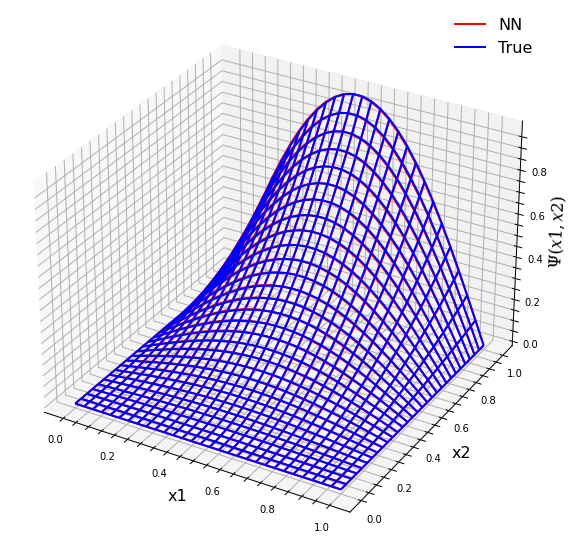

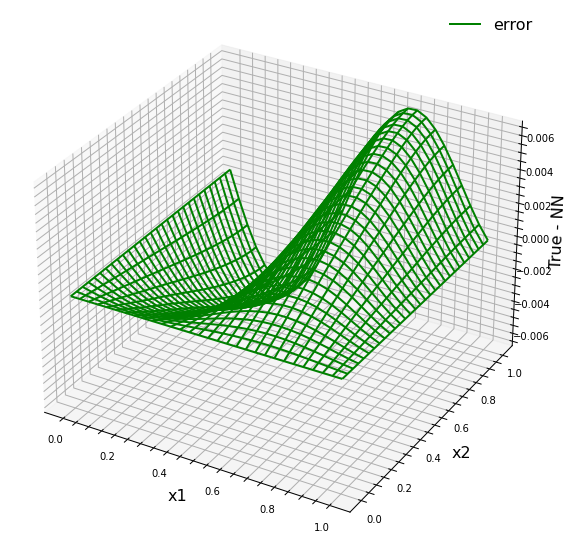

In [144]:
Data = np.load(path + "x1_x2_y.npz")
y_pred = Data['y'].reshape(30,30)
y_pred = torch.tensor(y_pred)
 
x1,x2 = torch.meshgrid(x_test1,x_test2)
y_true = x2**2*torch.sin(math.pi*x1)
y_err = y_true - y_pred

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.tick_params(labelsize=10)
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), y_pred.detach().numpy(),label='NN',color='r')
ax.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), y_true.detach().numpy(),label='True',color='b')
ax.set(xlabel="x1",
       ylabel="x2",
       zlabel="$\Psi(x1,x2)$"
      )
plt.legend()
plt.savefig(path + "solution.png",dpi=100)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='3d')
ax1.tick_params(labelsize=10)
ax1.plot_wireframe(x1.detach().numpy(), x2.detach().numpy(), y_err.detach().numpy(),label='error',color='g')
ax1.set(xlabel="x1",
       ylabel="x2",
       zlabel="True - NN"
      )
plt.legend()
plt.savefig(path + "Error.png",dpi=100)